In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
from numpy import median
from bs4 import BeautifulSoup
import requests
import urllib.request, urllib.parse, urllib.error
import json

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

/Users/nickcatalano/opt/anaconda3/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


1.  Importing data from .csv files

In [2]:
data_folder = 'zippedData/'

data_files = [
    'bom.movie_gross.csv.gz',
    'imdb.title.basics.csv.gz',
    'tn.movie_budgets.csv.gz',
]

df = []

for i in range(len(data_files)):
    df.append(pd.read_csv(data_folder + data_files[i]))

# Removing and Adjusting Datatype of Columns in df[0]
df[0].drop(['studio', 'year'], axis=1, inplace=True)
df[0]['domestic_gross'] = pd.to_numeric(df[0]['domestic_gross'], errors='coerce')
df[0]['foreign_gross'] = pd.to_numeric(df[0]['foreign_gross'], errors='coerce')
df[0].head()

# Removing and Renaming Columns in df[1]
df[1].drop(['tconst', 'original_title', 'start_year', 'runtime_minutes'], axis=1, inplace=True)
df[1] = df[1].rename(columns={'primary_title': 'title'})

# Removing, Renaming, and Adjusting Datatype of Columns in df3
df[2].drop(['id'], axis=1, inplace=True)
df[2]['release_date'] = pd.to_datetime(df[2]['release_date'])
df[2].sort_values('release_date', inplace = True)
df[2] = df[2].rename(columns={'movie': 'title'})
df[2][df[2].columns[2:]] = df[2][df[2].columns[2:]].replace('[\$,]', '', regex=True).astype(float)
df[2] = df[2][df[2]['release_date'].dt.year >= 2010]

<>:29: DeprecationWarning: invalid escape sequence \$


In [3]:
df[0].head()

,title,domestic_gross,foreign_gross
0,Toy Story 3,415000000.0,652000000.0
1,Alice in Wonderland (2010),334200000.0,691300000.0
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000.0
3,Inception,292600000.0,535700000.0
4,Shrek Forever After,238700000.0,513900000.0


In [4]:
df[1].head()

,title,genres
0,Sunghursh,"Action,Crime,Drama"
1,One Day Before the Rainy Season,"Biography,Drama"
2,The Other Side of the Wind,Drama
3,Sabse Bada Sukh,"Comedy,Drama"
4,The Wandering Soap Opera,"Comedy,Drama,Fantasy"


In [5]:
df[2].head()

,release_date,title,production_budget,domestic_gross,worldwide_gross
2812,2010-01-08,Youth in Revolt,18000000.0,15285588.0,19685588.0
2739,2010-01-08,Leap Year,19000000.0,25918920.0,32618920.0
2566,2010-01-08,Daybreakers,20000000.0,30101577.0,51445503.0
2067,2010-01-15,The Spy Next Door,28000000.0,24307106.0,46752858.0
4735,2010-01-15,Fish Tank,3000000.0,374675.0,5922292.0


2.  Webscrapping data

In [6]:
# Making soup

numbers_url = {}
for year in range(2010, 2020):
    numbers_url[year] = 'https://www.the-numbers.com/market/%s/top-grossing-movies' % year
numbers_response = {}
for year in range(2010, 2020):
    numbers_response[year] = requests.get(numbers_url[year])
numbers_soup = {}
for year in range(2010, 2020):
    numbers_soup[year] = BeautifulSoup(numbers_response[year].text, 'lxml')

In [7]:
# Containers

# Container with Table
numbers_warning = {}
for year in range(2010, 2020):
    numbers_warning[year] = numbers_soup[year].find('table')

# Container with General Information
numbers_infocontainer = {}
for year in range (2010, 2020):
    numbers_infocontainer[year] = numbers_warning[year].find_all('tr')

In [8]:
#Scraping movies

numbers_movies = []
numbers_dates = []
numbers_genres = []
numbers_gross = []

def numbers_data_pull(data,index):
        phrase = data.find_all('td', class_='data')[index].get_text()
        phrases = phrase.split('$')[1]
        return int(phrases.replace(',',''))

for year in range (2010, 2020):
    for a in range(1, len(numbers_infocontainer[year])-2):
        numbers_movies.append(numbers_infocontainer[year][a].find_all('a')[0].get_text())
        numbers_dates.append(numbers_infocontainer[year][a].find_all('a')[1].get_text())
        numbers_gross.append(numbers_data_pull(numbers_infocontainer[year][a],1))
      
        try:
            numbers_genres.append(numbers_infocontainer[year][a].find_all('a')[3].get_text())
        except:
            numbers_genres.append(None)

In [9]:
# Making more soup

pages = []
pagesetup = 1
while pagesetup <= 6001:
    pages.append(pagesetup)
    pagesetup +=100

morenumbers_url = {}
for page in pages:
    morenumbers_url[page] = 'https://www.the-numbers.com/movie/budgets/all/%s' % page
morenumbers_url[1] = 'https://www.the-numbers.com/movie/budgets/all'

morenumbers_response = {}
for page in pages:
    morenumbers_response[page] = requests.get(morenumbers_url[page])

    morenumbers_soup = {}
for page in pages:
    morenumbers_soup[page] = BeautifulSoup(morenumbers_response[page].text, 'lxml')

In [10]:
# Container with Table
morenumbers_warning = {}
for page in pages:
    morenumbers_warning[page] = morenumbers_soup[page].find('table')

# Container with General Information
morenumbers_infocontainer = {}
for page in pages:
    morenumbers_infocontainer[page] = morenumbers_warning[page].find_all('tr')

In [11]:
morenumbers_movies = []
morenumbers_production = []
morenumbers_domestic = []
morenumbers_worldwide = []

def numbers_data_pull(data,index):
        phrase = data.find_all('td', class_='data')[index].get_text()
        phrases = phrase.split('$')[1]
        return int(phrases.replace(',',''))


for page in pages:
    for a in range(1, len(morenumbers_infocontainer[page])):
        morenumbers_movies.append(morenumbers_infocontainer[page][a].find_all('a')[1].get_text())
        morenumbers_production.append(numbers_data_pull(morenumbers_infocontainer[page][a],1))
        morenumbers_domestic.append(numbers_data_pull(morenumbers_infocontainer[page][a],2))
        morenumbers_worldwide.append(numbers_data_pull(morenumbers_infocontainer[page][a],3))

In [12]:
numbers_df = pd.DataFrame([numbers_dates, numbers_movies, numbers_genres, numbers_gross]).transpose()
numbers_df.columns = ['release_date', 'title',  'genres', 'domestic_gross']
numbers_df.head()

,release_date,title,genres,domestic_gross
0,"Jun 18, 2010",Toy Story 3,Adventure,415004880
1,"Dec 18, 2009",Avatar,Action,408392727
2,"Mar 5, 2010",Alice in Wonderland,Adventure,334191110
3,"May 7, 2010",Iron Man 2,Action,312433331
4,"Jun 30, 2010",The Twilight Saga: Eclipse,Drama,300531751


In [13]:
morenumbers_df = pd.DataFrame([morenumbers_movies, morenumbers_production, morenumbers_domestic, morenumbers_worldwide]).transpose()
morenumbers_df.columns = ['title', 'production_budget', 'domestic_gross', 'worldwide_gross']
morenumbers_df['foreign_gross'] = morenumbers_df['worldwide_gross'] - morenumbers_df['domestic_gross']
morenumbers_df.head()

,title,production_budget,domestic_gross,worldwide_gross,foreign_gross
0,Avengers: Endgame,400000000,858373000,2797800564,1939427564
1,Pirates of the Caribbean: On Stranger Tides,379000000,241063875,1045663875,804600000
2,Avengers: Age of Ultron,365000000,459005868,1396099202,937093334
3,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2065478084,1128815859
4,Avengers: Infinity War,300000000,678815482,2048359754,1369544272


In [14]:
mergednumbers_df = numbers_df.merge(morenumbers_df, on='title', how='left')
mergednumbers_df['domestic_gross'] = mergednumbers_df[['domestic_gross_x','domestic_gross_y']].max(axis=1)
mergednumbers_df.drop(['domestic_gross_x', 'domestic_gross_y'], axis=1, inplace=True)
mergednumbers_df['release_date'] = pd.to_datetime(mergednumbers_df['release_date'], errors='coerce')

df_columns = ['release_date', 'title', 'genres', 
              'production_budget', 'domestic_gross', 
              'foreign_gross', 'worldwide_gross']

mergednumbers_df = mergednumbers_df.reindex(columns=df_columns)
mergednumbers_df.sort_values('release_date', inplace = True)
mergednumbers_df.head()

,release_date,title,genres,production_budget,domestic_gross,foreign_gross,worldwide_gross
5301,1926-01-07,Moana,Documentary,150000000,248757044.0,387679108,636436152
984,1927-03-13,Metropolis,Action,15000000,673414.0,731618,1405032
1866,1938-09-12,La Grande Illusion,None,NaN,71641.0,NaN,NaN
5291,1942-12-25,Arabian Nights,Adventure,NaN,3719.0,NaN,NaN
7506,1945-11-30,Detour,Drama,NaN,1540.0,NaN,NaN


# imdb API data

In [15]:
API_key = '294f4c0e6d0861470f47e84017c8e2c1'

In [16]:
#The first API function is to obtain a list of movies for a given year with the filter of vote_count.

def API_search(year,vote_count):
    #This request pulls the first page of the search request
    resp = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' + str(API_key) +'&language=en-US&vote_count.gte='+str(vote_count)+'&primary_release_year='+ str(year))
    data_p1 = dict(resp.json())

    #We can also use this request to see how many pages there are in the search, 
    #we will need to add all the pages of the search to the dataframe
    search_pages = data_p1['total_pages']
    data = pd.DataFrame.from_dict(data_p1['results'])
    url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + str(API_key) +'&language=en-US&vote_count.gte='+str(vote_count)+'&primary_release_year='+ str(year)+'&page='
    for page in range(2,search_pages+1):
        resp = requests.get(url + str(page))
        temp = dict(resp.json())
        df_by_page = pd.DataFrame.from_dict(temp['results'])
        data = pd.concat([data,df_by_page], ignore_index=True)

    data = data.set_index('id')
    # Create a list of all the movies from the search above. Which is in decending popularity order.
    return data.index.values.tolist()

In [17]:
#Use the API function above to create a list of movies between the years given what at leave the vote_count defined.

movies_index = []

vote_count = 1000
search_years = list(range(2010,2020))

for year in search_years:
    movies_index = movies_index + API_search(year,vote_count)
    
movies_index[:5]

[27205, 12444, 10138, 10193, 11324]

In [18]:
#Here is an example of the API request data.  
#If we want to change our dataframes, to target more data, it would be easy to add in the function in an upcoming step
resp = requests.get('https://api.themoviedb.org/3/movie/' + str(movies_index[0]) + '?api_key=' + str(API_key))
dict(resp.json())

{'adult': False,
 'backdrop_path': '/s3TBrRGB1iav7gFOCNx3H31MoES.jpg',
 'belongs_to_collection': None,
 'budget': 160000000,
 'genres': [{'id': 28, 'name': 'Action'},
  {'id': 878, 'name': 'Science Fiction'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'http://inceptionmovie.warnerbros.com/',
 'id': 27205,
 'imdb_id': 'tt1375666',
 'original_language': 'en',
 'original_title': 'Inception',
 'overview': 'Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: "inception", the implantation of another person\'s idea into a target\'s subconscious.',
 'popularity': 72.287,
 'poster_path': '/9gk7adHYeDvHkCSEqAvQNLV5Uge.jpg',
 'production_companies': [{'id': 923,
   'logo_path': '/5UQsZrfbfG2dYJbx8DxfoTr2Bvu.png',
   'name': 'Legendary Entertainment',
   'origin_country': 'US'},
  {'id': 9996,
   'logo_path': '/3tvBqYsBhxWeHlu62SIJ1el93O7.png',
   'n

In [19]:
#Defines a function to then arrange the data into a dictionary for a given movie.  

def API_request(movie):
    resp = requests.get('https://api.themoviedb.org/3/movie/' + str(movie) + '?api_key=' + str(API_key))
    if resp.status_code == requests.codes.ok:
        temp = dict(resp.json())
        movie = {}
        movie['imdb_id'] = temp['imdb_id']
        movie['popularity'] = temp['popularity']
        movie['release_date'] = pd.to_datetime(temp['release_date'])
        movie['genres'] = [genre['name'] for genre in temp['genres']]
        movie['title'] = temp['title']
        movie['budget'] = int(temp['budget'])
        movie['revenue'] = int(temp['revenue'])
        movie['runtime_mins'] = temp['runtime']
        movie['vote_average'] = temp['vote_average']        
        movie['vote_count'] = temp['vote_count']   
        return movie

In [20]:
#See an example of what the API_request provides per movie
print(API_request(movies_index[0]))

{'imdb_id': 'tt1375666', 'popularity': 72.287, 'release_date': Timestamp('2010-07-15 00:00:00'), 'genres': ['Action', 'Science Fiction', 'Adventure'], 'title': 'Inception', 'budget': 160000000, 'revenue': 825532764, 'runtime_mins': 148, 'vote_average': 8.3, 'vote_count': 26575}


In [21]:
# LONG RUNTIME #

#Make requests to the API for the movie data
imbd_API_data = list(map(lambda x: API_request(x),movies_index))

In [22]:
#Create a dataframe of the data obtained
imdb_raw_df = pd.DataFrame.from_dict(imbd_API_data)
imdb_df = pd.DataFrame.from_dict(imbd_API_data)

# Exploring the different pulling data strategies

Validating the three methods of import/gathering data 

In [23]:
# Data files provided by flatiron.
df[2][df[2]['title'] == 'Alice in Wonderland']

,release_date,title,production_budget,domestic_gross,worldwide_gross
50,2010-03-05,Alice in Wonderland,200000000.0,334191110.0,1.025491e+09


In [24]:
# Webscraping Numbers
mergednumbers_df[mergednumbers_df['title'] == 'Alice in Wonderland']

,release_date,title,genres,production_budget,domestic_gross,foreign_gross,worldwide_gross
3,2010-03-05,Alice in Wonderland,Adventure,3000000,334191110.0,0,0
2,2010-03-05,Alice in Wonderland,Adventure,200000000,334191110.0,691300000,1025491110


In [25]:
# Data files provided by imdb_API.
imdb_df[imdb_df['title'] == 'Alice in Wonderland']

,imdb_id,popularity,release_date,genres,title,budget,revenue,runtime_mins,vote_average,vote_count
12,tt1014759,21.536,2010-03-03,"[Family, Fantasy, Adventure]",Alice in Wonderland,200000000,1025467110,108,6.6,10386


# Merging dataframes

In [26]:
# Flatiron data file merging
merged_df1 = pd.merge(df[0], df[1], how='outer', on='title')
merged_df1.head()

# Merging df3 to df1/df2
merged_df2 = pd.merge(merged_df1, df[2], how='outer', on='title')

# Editting NaN Values for Easier Merging and Data Analysis
merged_df2['domestic_gross'] = merged_df2[['domestic_gross_x','domestic_gross_y']].max(axis=1)
merged_df2.drop(['domestic_gross_x', 'domestic_gross_y'], axis=1, inplace=True)
merged_df2.dropna(subset=['release_date'], inplace = True)

merged_df2.head()

,title,foreign_gross,genres,release_date,production_budget,worldwide_gross,domestic_gross
0,Toy Story 3,652000000.0,"Adventure,Animation,Comedy",2010-06-18,200000000.0,1.068880e+09,415004880.0
3,Inception,535700000.0,"Action,Adventure,Sci-Fi",2010-07-16,160000000.0,8.355246e+08,292600000.0
4,Shrek Forever After,513900000.0,"Adventure,Animation,Comedy",2010-05-21,165000000.0,7.562447e+08,238736787.0
5,The Twilight Saga: Eclipse,398000000.0,"Adventure,Drama,Fantasy",2010-06-30,68000000.0,7.061028e+08,300531751.0
6,Iron Man 2,311500000.0,"Action,Adventure,Sci-Fi",2010-05-07,170000000.0,6.211564e+08,312433331.0


In [27]:
#Merging Flatiron data with Numbers Data into a "Master_Dataframe"
merged_df3 = pd.merge(merged_df2, mergednumbers_df, how='outer', on='title')
merged_df3.drop(['release_date_x'], axis=1, inplace=True)
merged_df3 = merged_df3.rename(columns={'release_date_y': 'release_date'})
merged_df3.head()

,title,foreign_gross_x,genres_x,production_budget_x,worldwide_gross_x,domestic_gross_x,release_date,genres_y,production_budget_y,domestic_gross_y,foreign_gross_y,worldwide_gross_y
0,Toy Story 3,652000000.0,"Adventure,Animation,Comedy",200000000.0,1.068880e+09,415004880.0,2010-06-18,Adventure,200000000,415004880.0,653874642,1068879522
1,Inception,535700000.0,"Action,Adventure,Sci-Fi",160000000.0,8.355246e+08,292600000.0,2010-07-16,Thriller/Suspense,160000000,292576195.0,539975766,832551961
2,Inception,535700000.0,"Action,Adventure,Sci-Fi",160000000.0,8.355246e+08,292600000.0,2010-07-16,Thriller/Suspense,160000000,292576195.0,539975766,832551961
3,Shrek Forever After,513900000.0,"Adventure,Animation,Comedy",165000000.0,7.562447e+08,238736787.0,2010-05-21,Adventure,165000000,238736787.0,517507886,756244673
4,The Twilight Saga: Eclipse,398000000.0,"Adventure,Drama,Fantasy",68000000.0,7.061028e+08,300531751.0,2010-06-30,Drama,68000000,300531751.0,405571077,706102828


In [28]:
#Define a function that will compare two columns and return the maximum of those columns.
def max_value(dataframe,column_name):
        
    dataframe[column_name] = dataframe[[column_name+'_x',column_name+'_y']].max(axis=1)
    dataframe.drop([column_name+'_x',column_name+'_y'], axis=1, inplace=True)
    
    return dataframe

In [29]:
# Condensing/Cleaning Columns of flatiron data and numbers data

columns_max_value = ['foreign_gross', 'production_budget','worldwide_gross','domestic_gross']

for column in columns_max_value:
    max_value(merged_df3,column)

merged_df3.head()

,title,genres_x,release_date,genres_y,foreign_gross,production_budget,worldwide_gross,domestic_gross
0,Toy Story 3,"Adventure,Animation,Comedy",2010-06-18,Adventure,653874642.0,200000000.0,1.068880e+09,415004880.0
1,Inception,"Action,Adventure,Sci-Fi",2010-07-16,Thriller/Suspense,539975766.0,160000000.0,8.355246e+08,292600000.0
2,Inception,"Action,Adventure,Sci-Fi",2010-07-16,Thriller/Suspense,539975766.0,160000000.0,8.355246e+08,292600000.0
3,Shrek Forever After,"Adventure,Animation,Comedy",2010-05-21,Adventure,517507886.0,165000000.0,7.562447e+08,238736787.0
4,The Twilight Saga: Eclipse,"Adventure,Drama,Fantasy",2010-06-30,Drama,405571077.0,68000000.0,7.061028e+08,300531751.0


In [30]:
#Merge the genres and remove duplicates
merged_df3['genres'] = merged_df3['genres_x'].str.cat(merged_df3['genres_y'], sep = ',')

unique_genres = []
for i in range(len(merged_df3)):
    if type(merged_df3['genres'][i]) == str:
         unique_genres.append(list(set(merged_df3['genres'][i].split(','))))
    else:
        unique_genres.append('None')

merged_df3.drop(['genres_x','genres_y'], axis=1, inplace=True)

merged_df3['genres'] = unique_genres


In [31]:
merged_df3.head()

,title,release_date,foreign_gross,production_budget,worldwide_gross,domestic_gross,genres
0,Toy Story 3,2010-06-18,653874642.0,200000000.0,1.068880e+09,415004880.0,"[Animation, Comedy, Adventure]"
1,Inception,2010-07-16,539975766.0,160000000.0,8.355246e+08,292600000.0,"[Action, Sci-Fi, Adventure, Thriller/Suspense]"
2,Inception,2010-07-16,539975766.0,160000000.0,8.355246e+08,292600000.0,"[Action, Sci-Fi, Adventure, Thriller/Suspense]"
3,Shrek Forever After,2010-05-21,517507886.0,165000000.0,7.562447e+08,238736787.0,"[Animation, Comedy, Adventure]"
4,The Twilight Saga: Eclipse,2010-06-30,405571077.0,68000000.0,7.061028e+08,300531751.0,"[Drama, Fantasy, Adventure]"


In [32]:
# Merging imbd_api df to master dataframe
merged_df4 = pd.merge(merged_df3, imdb_df, how='outer', on='title')

In [33]:
# Removing, Renaming, and Formatting Columns from imdb_data to merge
imdb_df = pd.DataFrame.from_dict(imbd_API_data)
imdb_df.drop(['popularity','imdb_id', 'runtime_mins', 'vote_average', 'vote_count'], axis=1, inplace=True)
imdb_df= imdb_df.rename(columns={'budget': 'production_budget', 'revenue': 'worldwide_gross'})
imdb_df.head()

,release_date,genres,title,production_budget,worldwide_gross
0,2010-07-15,"[Action, Science Fiction, Adventure]",Inception,160000000,825532764
1,2010-10-17,"[Adventure, Fantasy]",Harry Potter and the Deathly Hallows: Part 1,250000000,954305868
2,2010-04-28,"[Adventure, Action, Science Fiction]",Iron Man 2,200000000,623933331
3,2010-06-16,"[Animation, Family, Comedy]",Toy Story 3,200000000,1066969703
4,2010-02-14,"[Drama, Thriller, Mystery]",Shutter Island,80000000,294804195


In [34]:
# Merging imbd_api df to master dataframe
merged_df4 = pd.merge(merged_df3, imdb_df, how='outer', on='title')
merged_df4.drop(['release_date_x'], axis=1, inplace=True)
merged_df4 = merged_df4.rename(columns={'release_date_y': 'release_date'})


# Condensing/Cleaning Columns of flatiron data and numbers data
columns_max_value = ['production_budget','worldwide_gross']

for column in columns_max_value:
    max_value(merged_df4,column) 
    
unique_genres = []
for i in range(len(merged_df4)):
    if type(merged_df4['genres_x'][i]) == list:
        if type(merged_df4['genres_y'][i]) == float:
            unique_genres.append(merged_df4['genres_x'][i])
            continue
        else:
            unique_genres.append(list(set(list(merged_df4['genres_x'][i]) + list(merged_df4['genres_y'][i]))))
            continue

    if type(merged_df4['genres_x'][i]) == float:
        if type(merged_df4['genres_y'][i]) == list:
            unique_genres.append(merged_df4['genres_y'][i])
            continue
    
    else:
        unique_genres.append('None')

merged_df4.drop(['genres_x','genres_y'], axis=1, inplace=True)

merged_df4['genres'] = unique_genres

merged_df4.head()

,title,foreign_gross,domestic_gross,release_date,production_budget,worldwide_gross,genres
0,Toy Story 3,653874642.0,415004880.0,2010-06-16,200000000.0,1.068880e+09,"[Animation, Family, Comedy, Adventure]"
1,Inception,539975766.0,292600000.0,2010-07-15,160000000.0,8.355246e+08,"[Science Fiction, Thriller/Suspense, Sci-Fi, A..."
2,Inception,539975766.0,292600000.0,2010-07-15,160000000.0,8.355246e+08,"[Science Fiction, Thriller/Suspense, Sci-Fi, A..."
3,Shrek Forever After,517507886.0,238736787.0,2010-05-16,165000000.0,7.562447e+08,"[Fantasy, Comedy, Family, Adventure, Animation]"
4,The Twilight Saga: Eclipse,405571077.0,300531751.0,2010-06-23,68000000.0,7.061028e+08,"[Drama, Fantasy, Adventure, Romance]"


In [35]:
#Renaming 'Thriller/Suspense' to 'Thriller' and dropping duplicates.
for i in range(len(merged_df4)):
    for j in range(len(merged_df4.iloc[i]['genres'])):
        if merged_df4.iloc[i]['genres'][j] == 'Thriller/Suspense':
            merged_df4.iloc[i]['genres'][j] = 'Thriller'


In [36]:
#Dropping duplicate genres in the 'genres' column.
for i in range(len(merged_df4)):            
    merged_df4.iloc[i]['genres'] =set(merged_df4.iloc[i]['genres'])

# Calculating ROI "Return on Investment"

In [37]:
# Creating Function for ROI
def roi (gross, budget):
    percentage = (gross-budget)/budget * 100
    return (percentage)

merged_df4['roi'] = roi(merged_df4['worldwide_gross'], merged_df4['production_budget'])

merged_df4.head()

,title,foreign_gross,domestic_gross,release_date,production_budget,worldwide_gross,genres,roi
0,Toy Story 3,653874642.0,415004880.0,2010-06-16,200000000.0,1.068880e+09,"[Animation, Family, Comedy, Adventure]",434.439761
1,Inception,539975766.0,292600000.0,2010-07-15,160000000.0,8.355246e+08,"[Science Fiction, Thriller, Sci-Fi, Adventure,...",422.202901
2,Inception,539975766.0,292600000.0,2010-07-15,160000000.0,8.355246e+08,"[Science Fiction, Thriller, Sci-Fi, Adventure,...",422.202901
3,Shrek Forever After,517507886.0,238736787.0,2010-05-16,165000000.0,7.562447e+08,"[Fantasy, Comedy, Family, Adventure, Animation]",358.330105
4,The Twilight Saga: Eclipse,405571077.0,300531751.0,2010-06-23,68000000.0,7.061028e+08,"[Drama, Fantasy, Adventure, Romance]",938.386512


# Cleaning the data

In [38]:
# Removing Null/0 Data
final_df = merged_df4.dropna()
final_df = final_df[(final_df != 0).all(1)]

# Removing genres that are "None"
final_df = final_df[(final_df['genres'] != 'None')]

# Removing Movies Released Before 2010
final_df.drop(final_df[final_df['release_date'] < '2010-01-01'].index, inplace=True)

# Getting Rid of Duplicates
final_df = final_df.drop_duplicates(subset=['title'])

#Restructure dataframe
columnsorder = ['release_date', 'title', 'genres', 'production_budget', 'domestic_gross', 
                'foreign_gross', 'worldwide_gross', 'roi']
final_df = final_df.reindex(columns=columnsorder)
final_df = final_df.sort_values('release_date', ignore_index=True)

#Adding 'Year' column to better show trends over time.
final_df['year'] = final_df['release_date'].dt.year

#Adding 'genre_count' for plots
final_df['genres_count'] = [len(genres) for genres in final_df['genres']]

#Dividing the currency columns by $1M
columns = ['production_budget','domestic_gross','foreign_gross','worldwide_gross']
for i in range(len(columns)):
    final_df[columns[i]] = final_df[columns[i]] / 1000000

final_df.head()

,release_date,title,genres,production_budget,domestic_gross,foreign_gross,worldwide_gross,roi,year,genres_count
0,2010-01-08,Leap Year,"[Comedy, Romantic Comedy, Romance]",19.0,25.918920,6.700000,32.618920,71.678526,2010,3
1,2010-01-11,The Book of Eli,"[Drama, Science Fiction, Adventure, Thriller, ...",80.0,94.835059,63.915758,158.750817,98.438521,2010,5
2,2010-01-13,Devil,"[Thriller, Horror, Mystery]",10.0,33.679655,29.674459,63.354114,533.541140,2010,3
3,2010-01-21,Legion,"[Horror, Action, Thriller, Fantasy]",26.0,40.168080,27.479494,67.918658,161.225608,2010,4
4,2010-02-04,Dear John,"[Drama, Romance, War]",25.0,80.014842,62.018667,142.033509,468.134036,2010,3


# Defining functions to modify dataframes:
1. Function to remove outliers which will help visualize trends.
2. Expand the list of genres in the 'genres' column to indvidual rows.  To perform 'group by' the genre and investigate trends base don genres.

In [39]:
#Define a function to remove outliers based on columns to target
def iqr_data_filter(df, columns, ticker_width):

    q1 = df.quantile(0.25)                 
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    
    for column in columns:
        filter_lower = df[column] >= q1[column] - ticker_width * iqr[column]
        filter_upper = df[column] <= q3[column] + ticker_width * iqr[column]
        df = df[(filter_lower) & (filter_upper)]
      
    return df

In [40]:
#Define a function to expand the genres to their own rows per movie.
def genre_expand(dataframe):
    s = dataframe.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'genre'
    return dataframe.drop('genres',axis=1).join(s) 

# Plotting data

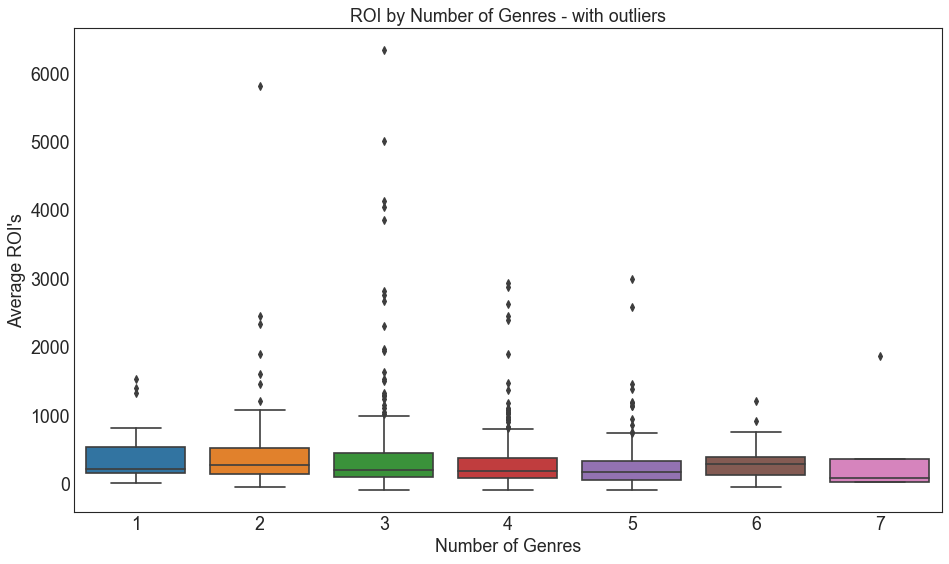

In [41]:
# Draw Plot

plt.figure(figsize=(14,8), dpi= 80)
sns.boxplot(x='genres_count', y='roi', data=final_df, notch=False)

# Add labels for x and y axes
plt.xlabel('Number of Genres')
plt.ylabel("Average ROI's")

# Add a title for the plot
plt.title('ROI by Number of Genres - with outliers')

plt.show()

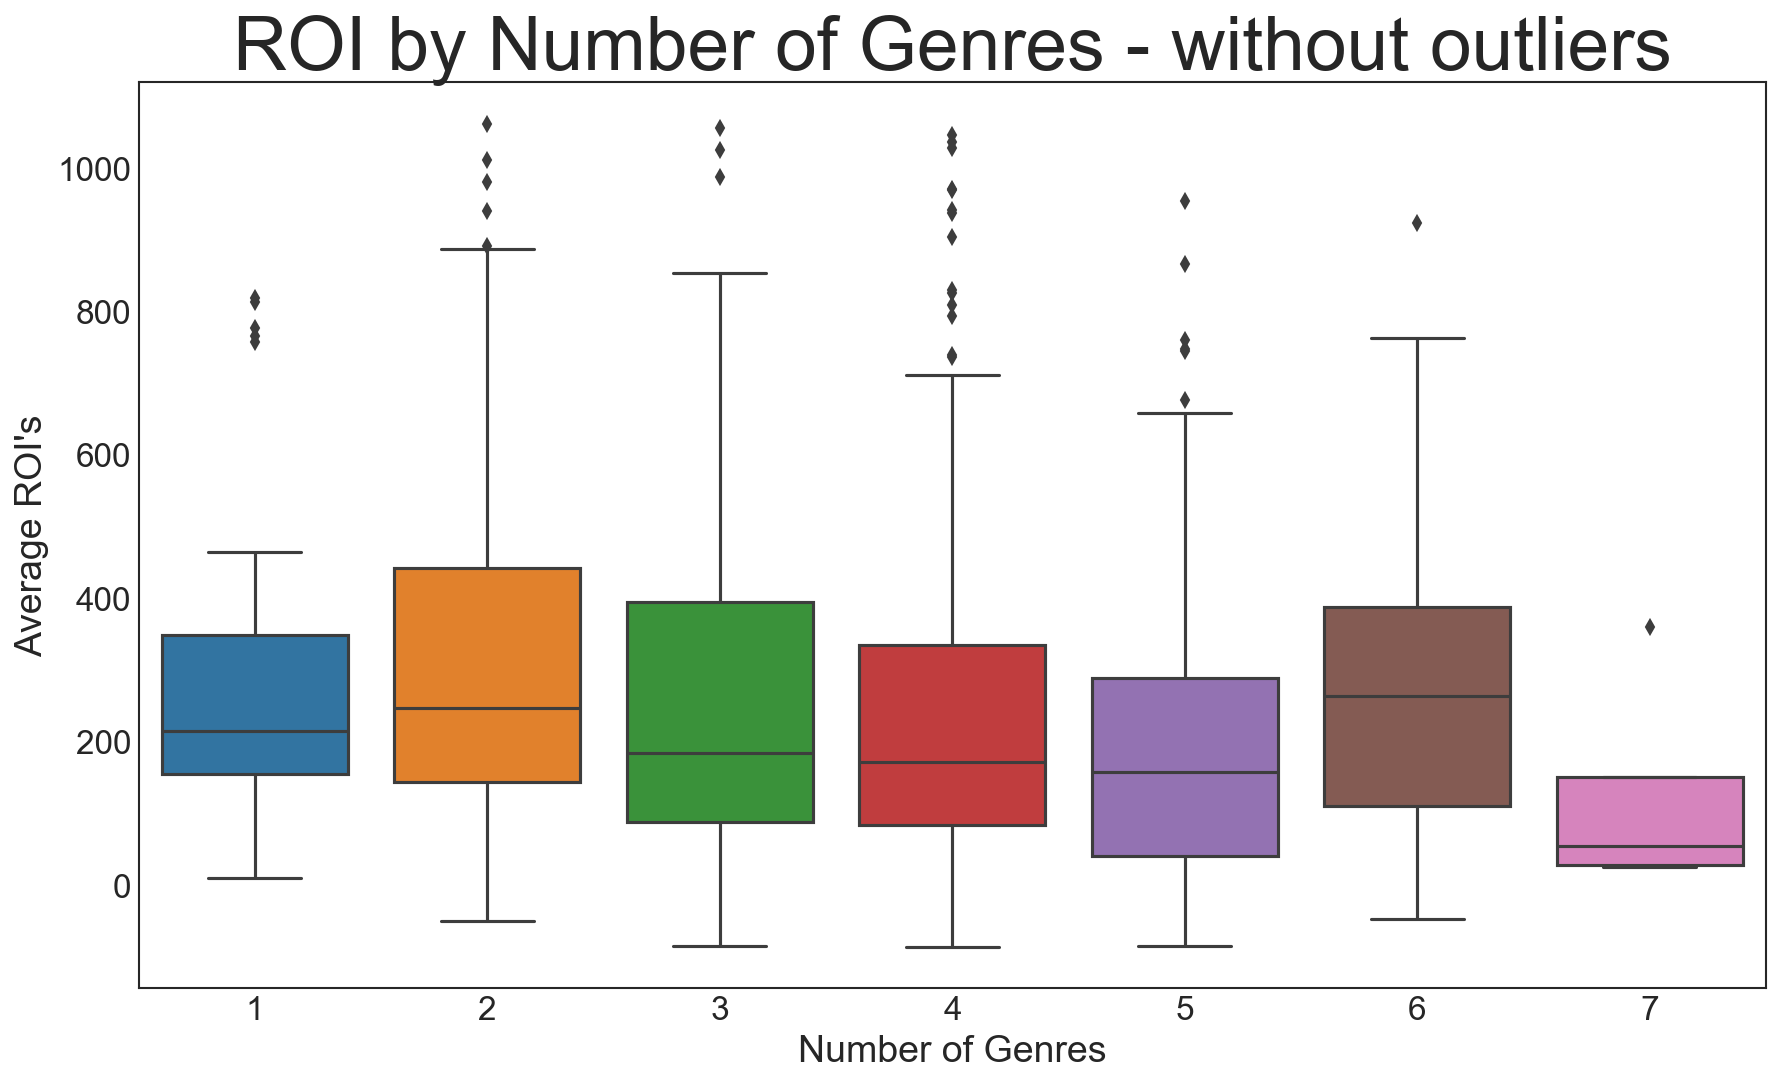

In [42]:
#Remove outliers based on'roi'.
col_to_filter = ['roi']
plot_df_filtered = iqr_data_filter(final_df, col_to_filter, 2)

# Draw Plot
plt.figure(figsize=(14,8), dpi= 150)
sns.boxplot(x='genres_count', y='roi', data=plot_df_filtered, notch=False)

# Add labels for x and y axes
plt.xlabel('Number of Genres', fontsize = 18)
plt.ylabel("Average ROI's", fontsize = 18)

# Add a title for the plot
plt.title('ROI by Number of Genres - without outliers', fontsize = 36)

plt.show()

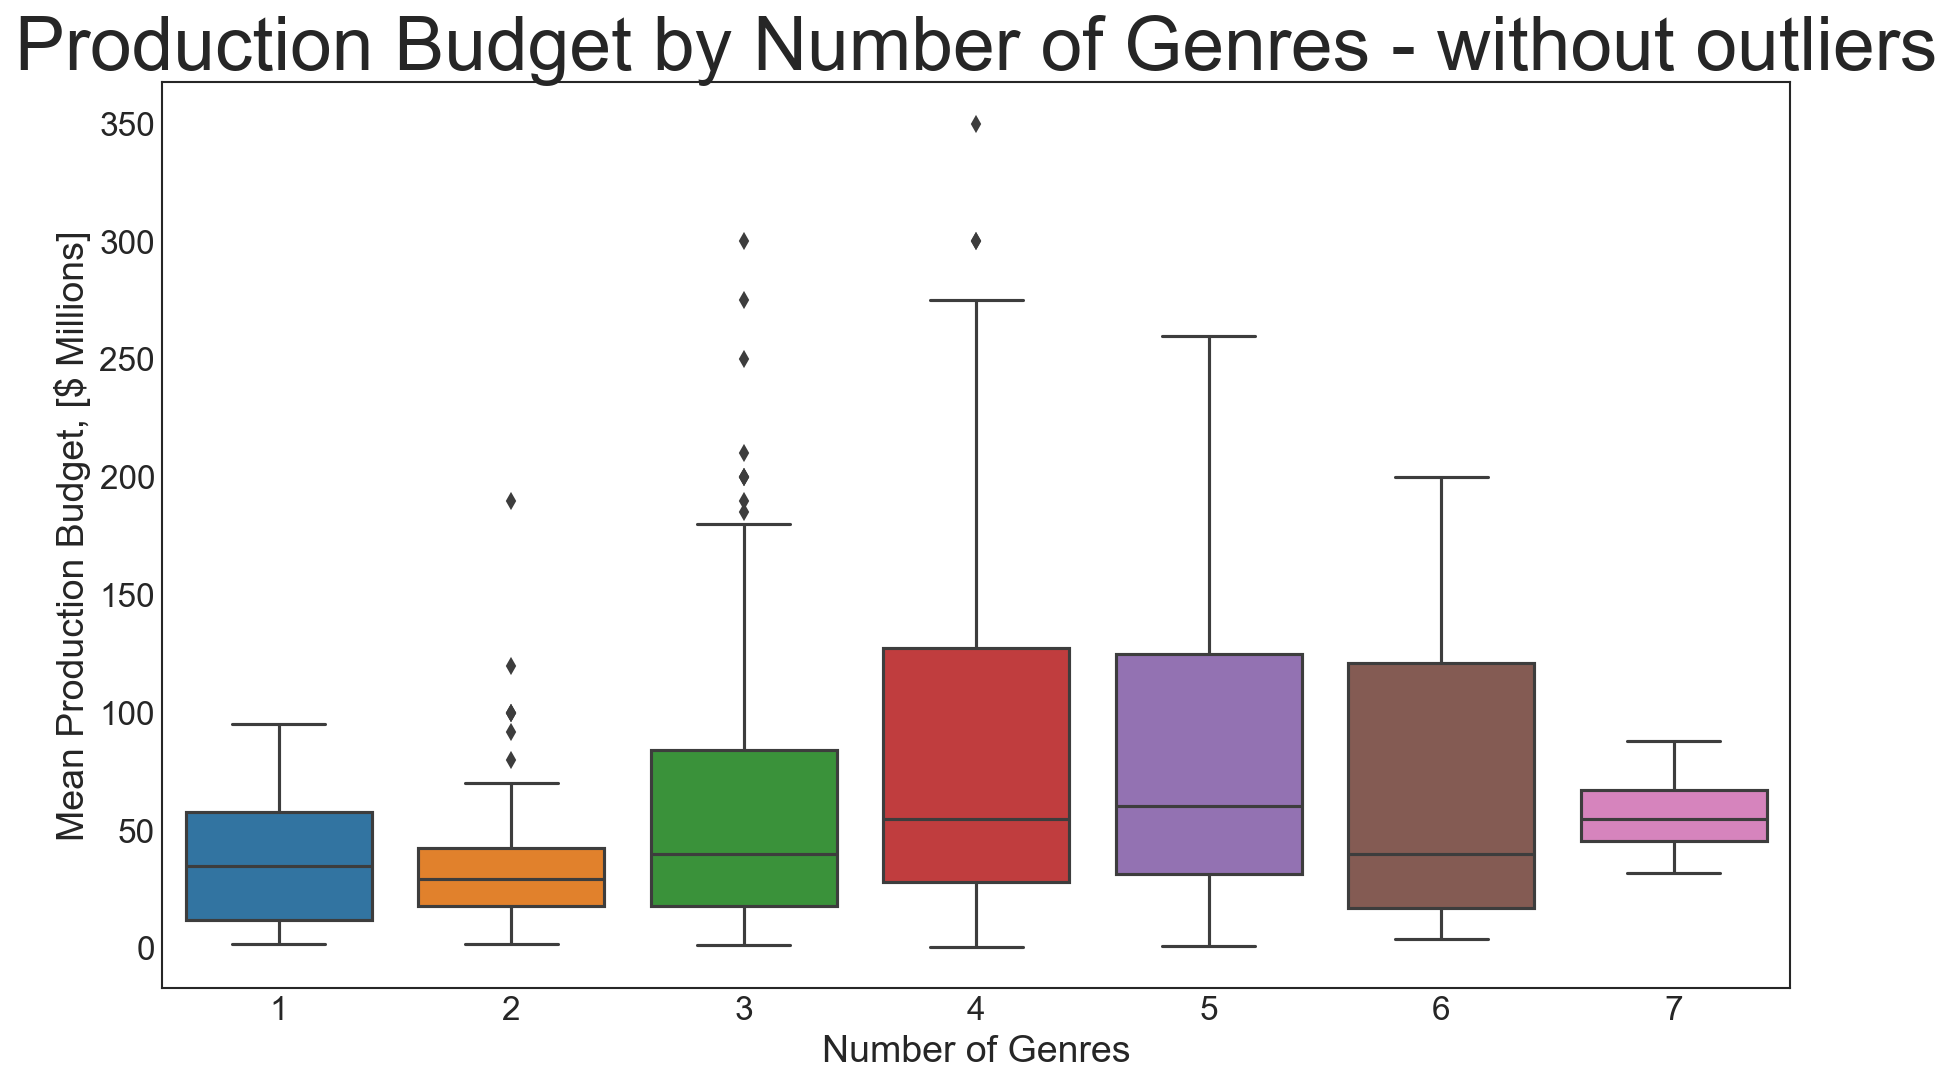

In [43]:
# Draw Plot
plt.figure(figsize=(14,8), dpi= 150)
sns.boxplot(x='genres_count', y='production_budget', data=plot_df_filtered, notch=False)

# Add labels for x and y axes
plt.xlabel('Number of Genres', fontsize = 18)
plt.ylabel("Mean Production Budget, [$ Millions]", fontsize = 18)

# Add a title for the plot
plt.title('Production Budget by Number of Genres - without outliers', fontsize = 36)

plt.show()

In [44]:
# Expanding the Genres column
plot_df_expanded = genre_expand(final_df)
plot_df_expanded.head()

,release_date,title,production_budget,domestic_gross,foreign_gross,worldwide_gross,roi,year,genres_count,genre
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Comedy
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Romantic Comedy
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Romance
1,2010-01-11,The Book of Eli,80.0,94.835059,63.915758,158.750817,98.438521,2010,5,Drama
1,2010-01-11,The Book of Eli,80.0,94.835059,63.915758,158.750817,98.438521,2010,5,Science Fiction


In [45]:
plot_df_expanded.describe()

,production_budget,domestic_gross,foreign_gross,worldwide_gross,roi,year,genres_count
count,2932.000000,2932.000000,2932.000000,2932.000000,2932.000000,2932.000000,2932.000000
mean,68.473838,91.007946,144.809628,238.217704,352.157196,2014.130286,4.070259
std,62.483807,102.764621,184.175794,279.360851,558.838194,2.600962,1.121047
min,0.100000,0.003200,0.003527,0.354836,-85.614037,2010.000000,1.000000
25%,20.000000,27.083165,27.800000,60.513177,84.666800,2012.000000,3.000000
50%,45.000000,54.724696,67.182926,129.109143,193.558203,2014.000000,4.000000
75%,100.000000,117.723989,193.200000,306.997961,406.088259,2016.000000,5.000000
max,350.000000,700.100000,1369.544272,2048.359754,6336.419800,2019.000000,7.000000


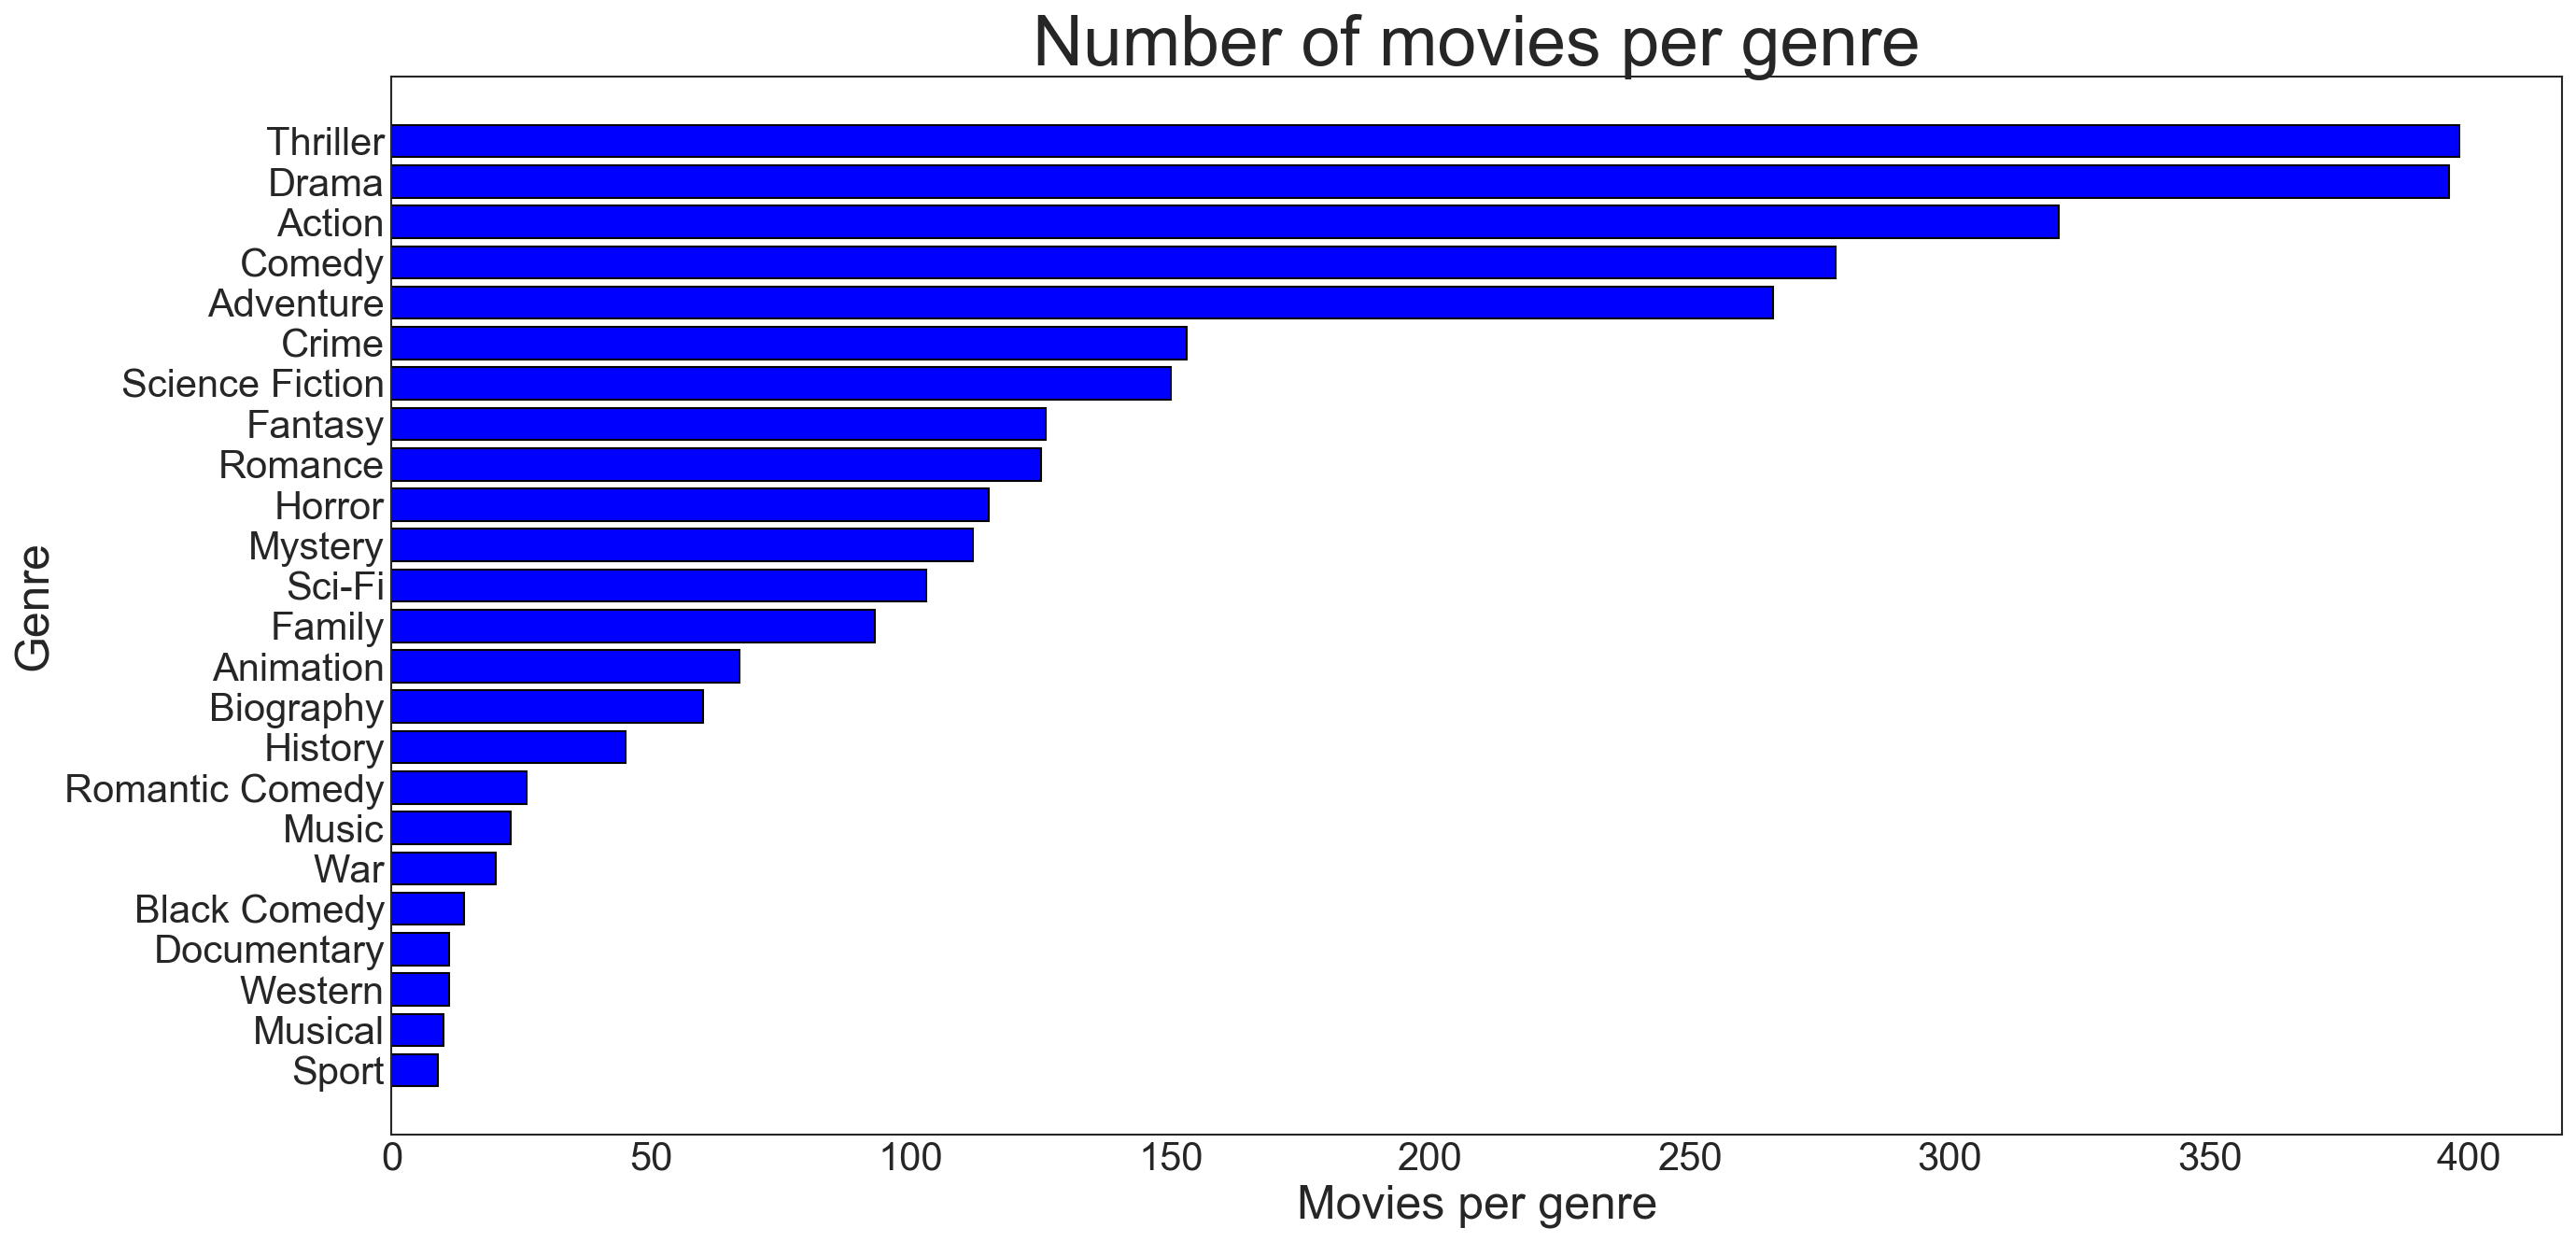

In [46]:
#What are the most common genres?
common_genres = {}
common_genres['count'] = plot_df_expanded.groupby(['genre']).count()['genres_count']
common_genres = pd.DataFrame.from_dict(common_genres).sort_values( by ='count', ascending = True)

plt.figure(figsize=(20,10), dpi= 150)
pos = np.arange(len(common_genres.index))
plt.barh(common_genres['count'].index,common_genres['count'],color='blue',edgecolor='black')
plt.xlabel('Movies per genre', fontsize=24)
plt.ylabel('Genre', fontsize=24)
plt.title('Number of movies per genre',fontsize=36)

ax = plt.gca()
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(20)

ay = plt.gca()
for tick in ay.xaxis.get_major_ticks():
    tick.label1.set_fontsize(20)
    
plt.show()


<Figure size 2400x3200 with 0 Axes>

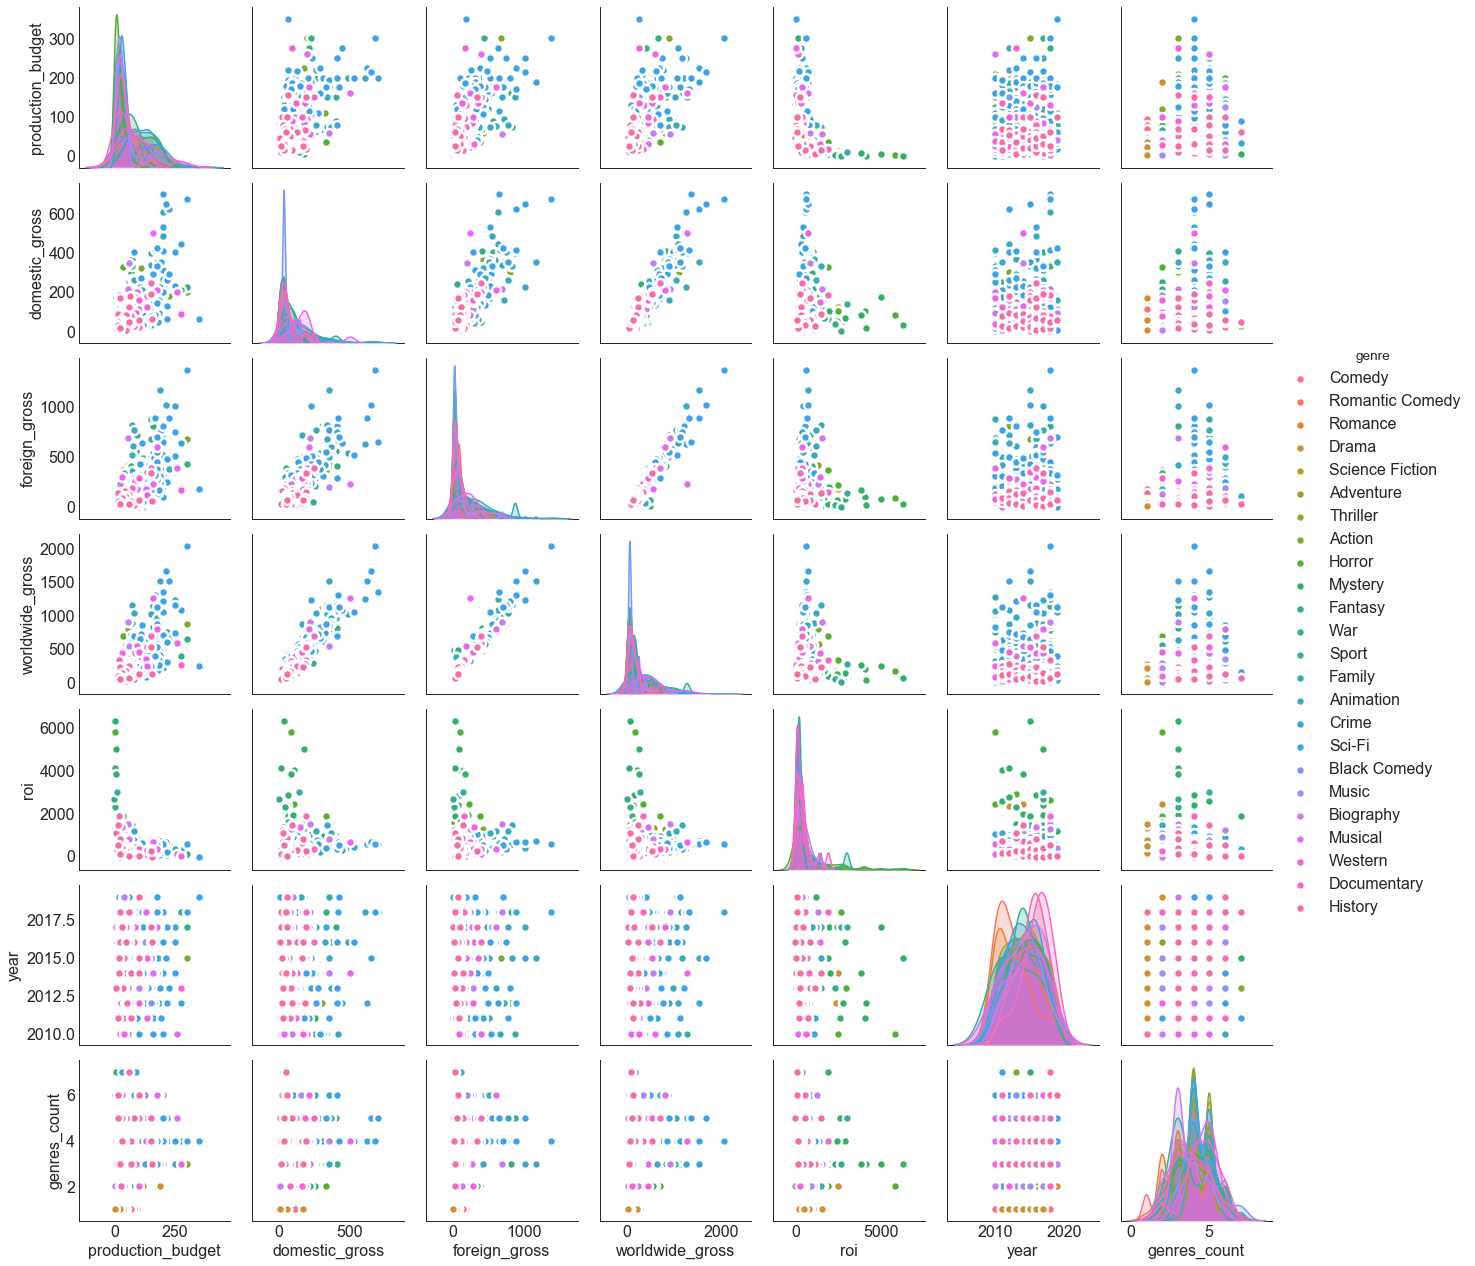

In [47]:
#A general overview of the masterDF
plt.figure(figsize=(6,8), dpi= 400)
sns.pairplot(plot_df_expanded, kind="scatter", hue="genre", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

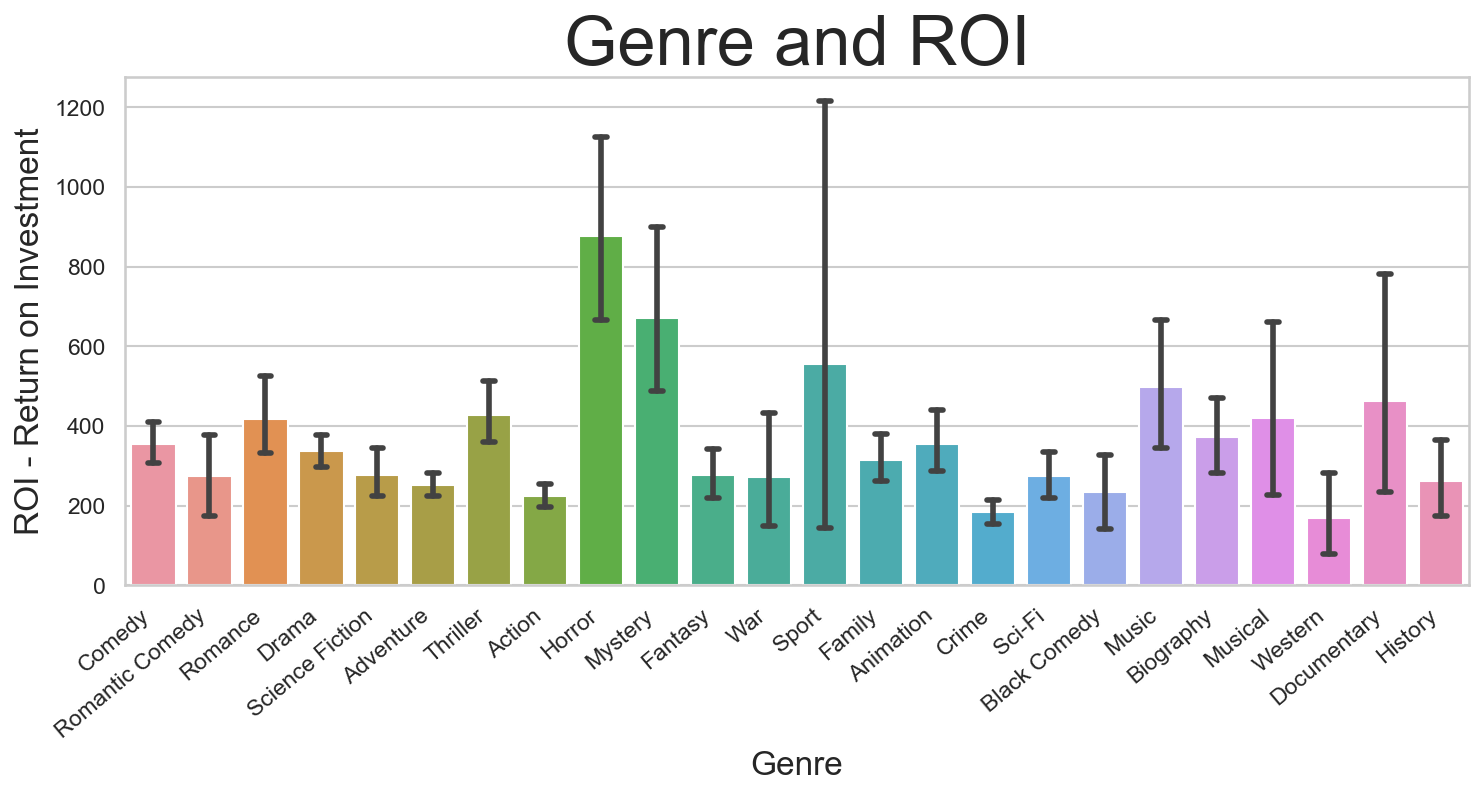

In [48]:
#Putting the above data in context with the larger DF
sns.set(style="whitegrid")
plt.figure(figsize=(10,5), dpi = 150)
ax = sns.barplot(x="genre", y="roi", data=plot_df_expanded, capsize=.2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment', fontsize = 16)
plt.xlabel("Genre", fontsize = 16)

# Add a title for the plot
plt.title('Genre and ROI', fontsize=33)

plt.show()

/Users/nickcatalano/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


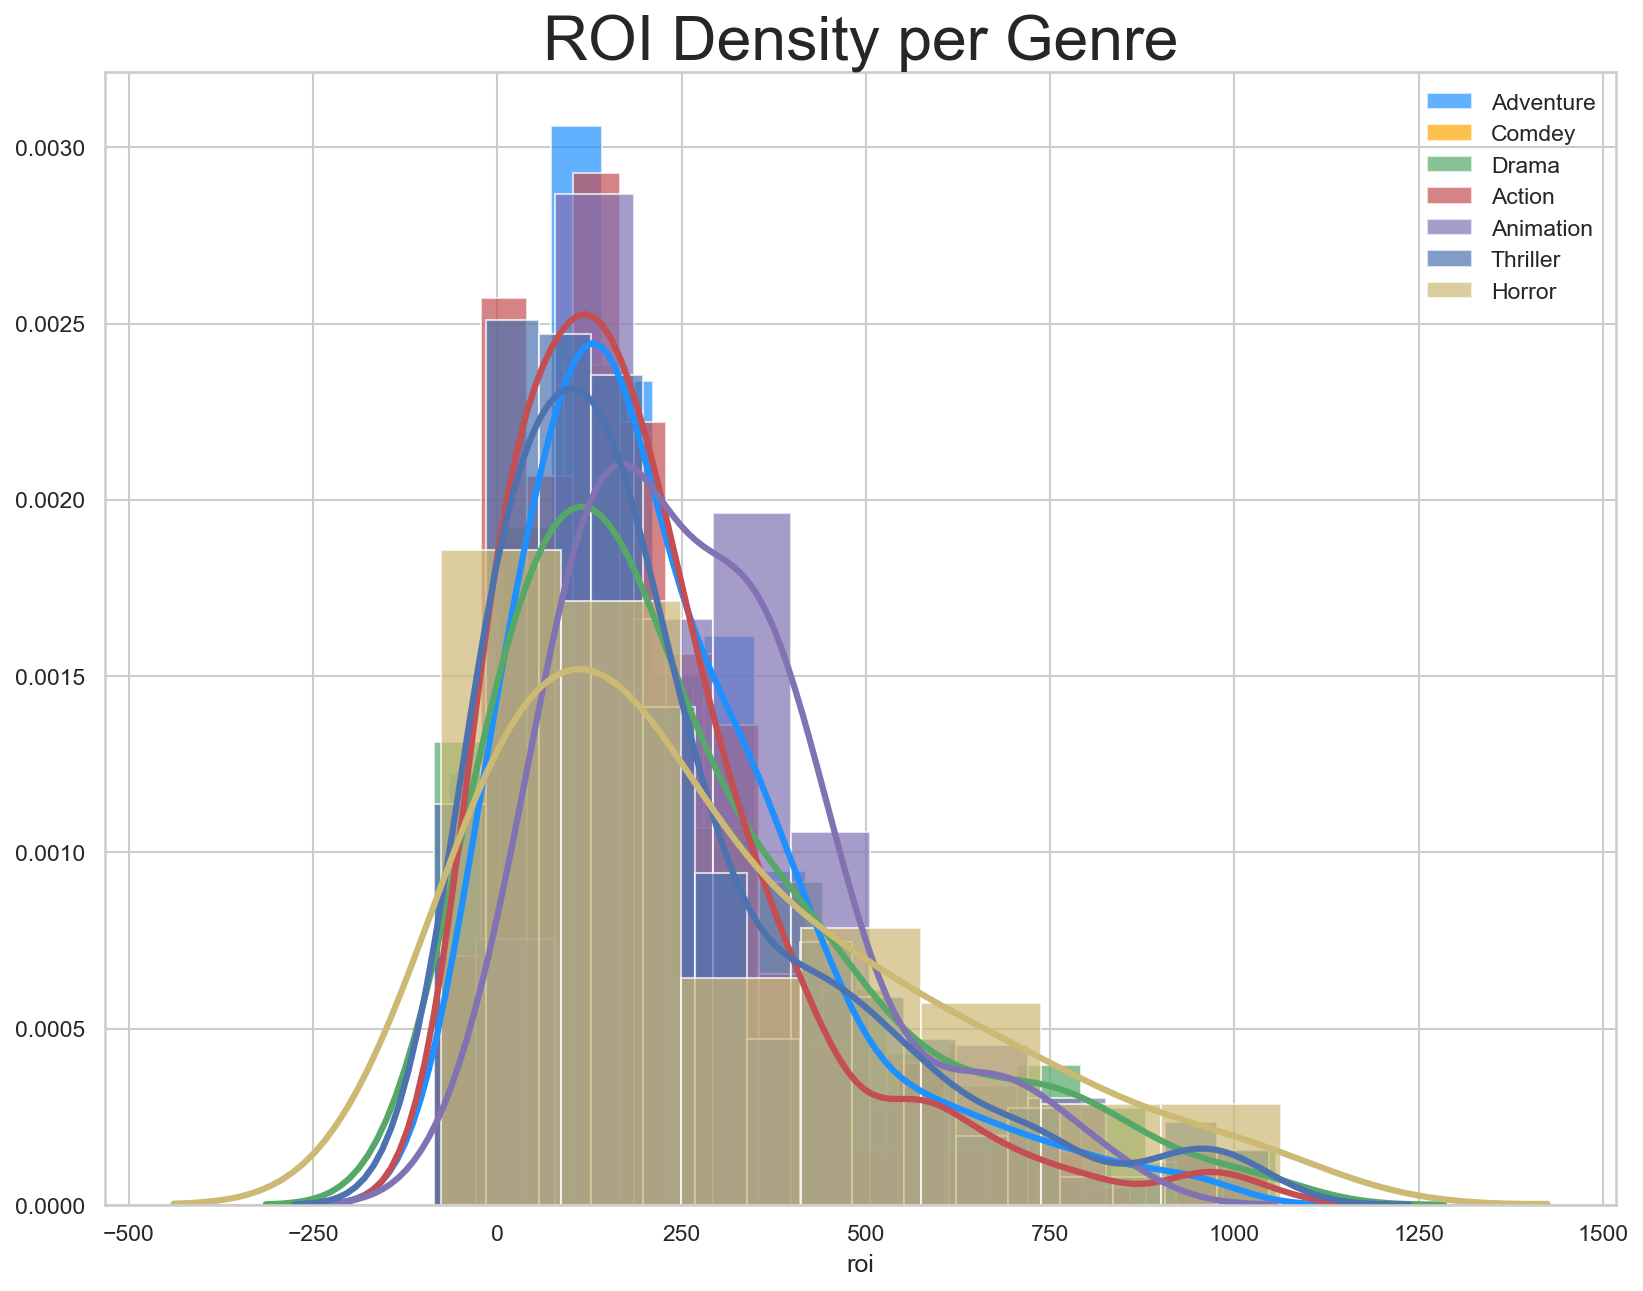

In [49]:
#Using the tables above, analyzing the density of the highest ROI genres. 

genre_dist_df = genre_expand(plot_df_filtered)


plt.figure(figsize=(13,10), dpi= 150)

genre_plot = ['Adventure','Comdey','Drama','Action','Animation','Thriller','Horror']
colors = ['dodgerblue','orange','g','r','m','b','y']

for i in range(len(genre_plot)):
    sns.distplot(genre_dist_df.loc[genre_dist_df['genre'] == genre_plot[i], "roi"], 
                 color = colors[i], 
                 label = genre_plot[i],
                 hist_kws={'alpha':.7}, 
                 kde_kws={'linewidth':3})

plt.title('ROI Density per Genre', fontsize=30)
plt.legend()
plt.show()


In [50]:
plot_df_expanded = plot_df_expanded[plot_df_expanded['roi'] > 175]

Text(0.5, 1.0, 'Trend of a genres ROI over last decade')

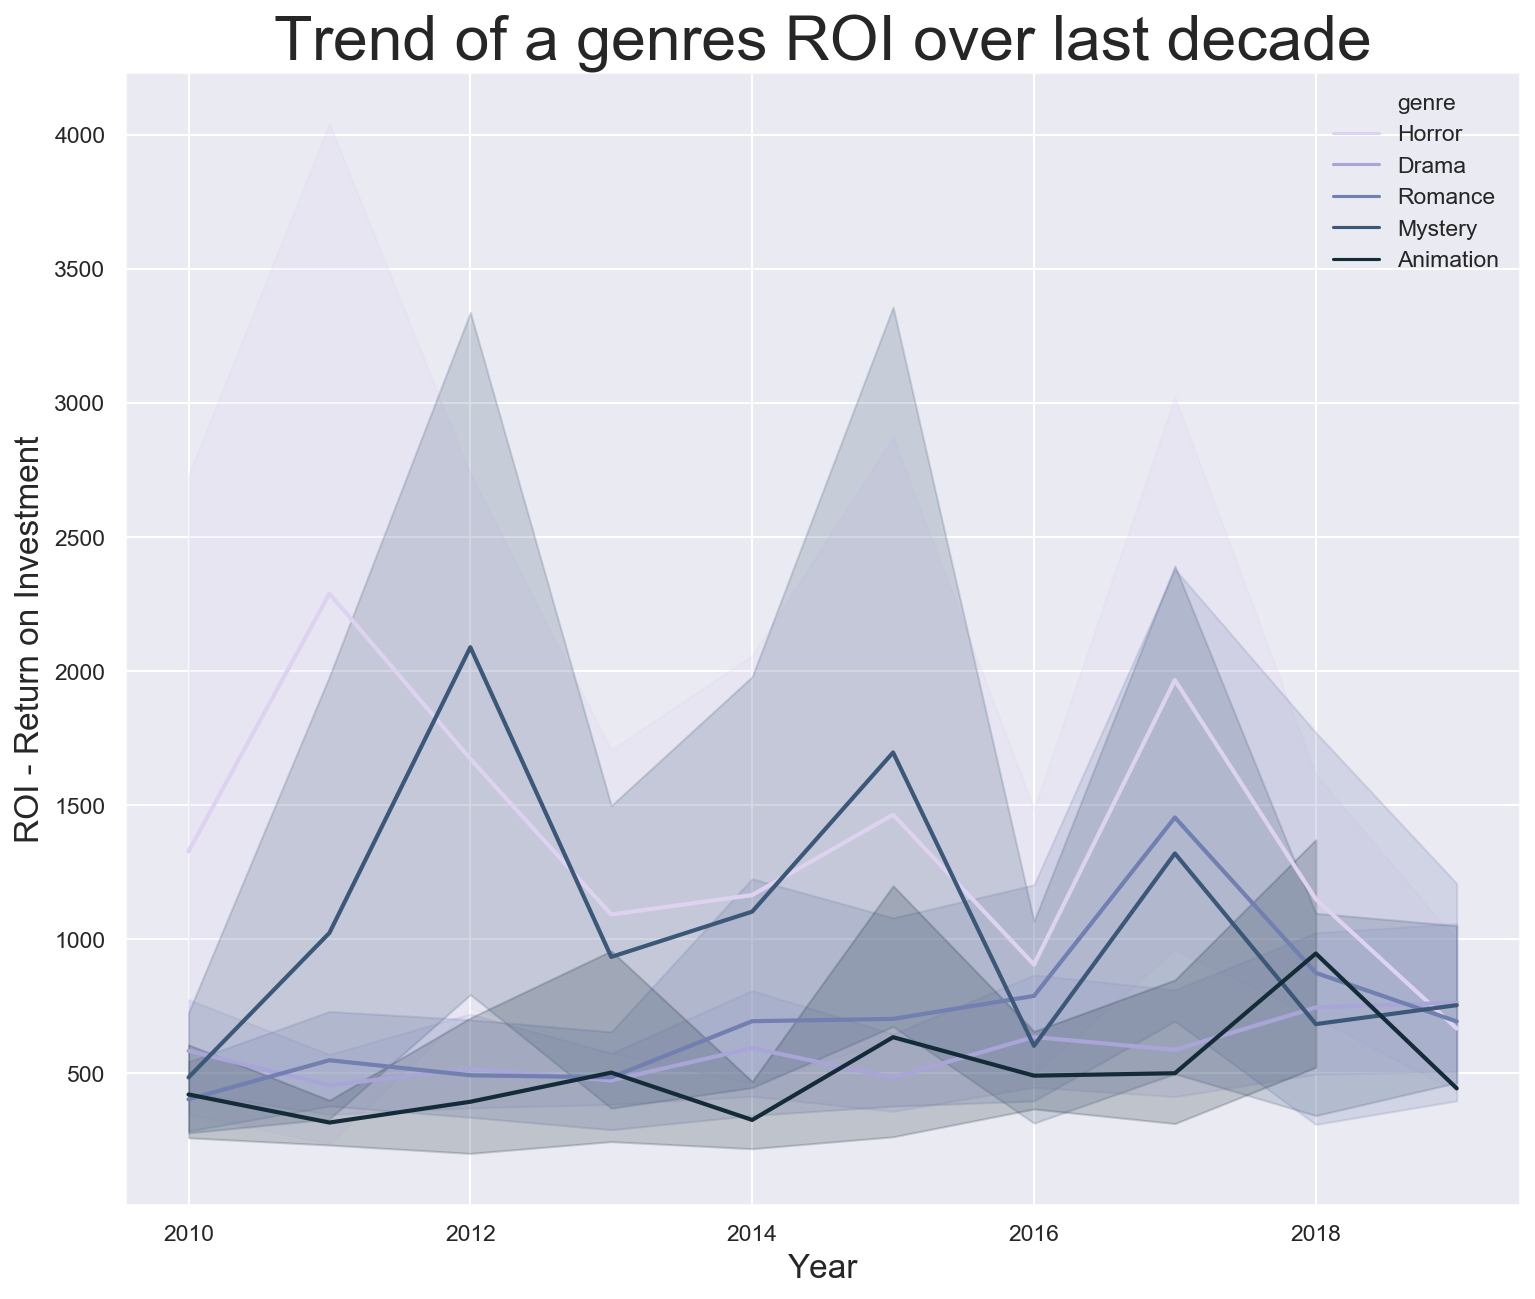

In [51]:
#Pulling out the highest ROI genres to finalize findings, identify trends
#Changing X to 'Year' to better display changes over time. 
sns.set(style="darkgrid")
plt.figure(figsize=(12,10), dpi = 150)
sns.lineplot(x="year", y="roi",
             hue="genre", hue_order=['Horror', 'Drama', 'Romance', 'Mystery','Animation'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.0)

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment', fontsize = 16)
plt.xlabel("Year", fontsize = 16)

# Add a title for the plot
plt.title('Trend of a genres ROI over last decade', fontsize = 30)

Text(0.5, 1.0, 'Trend of a genres ROI over last decade')

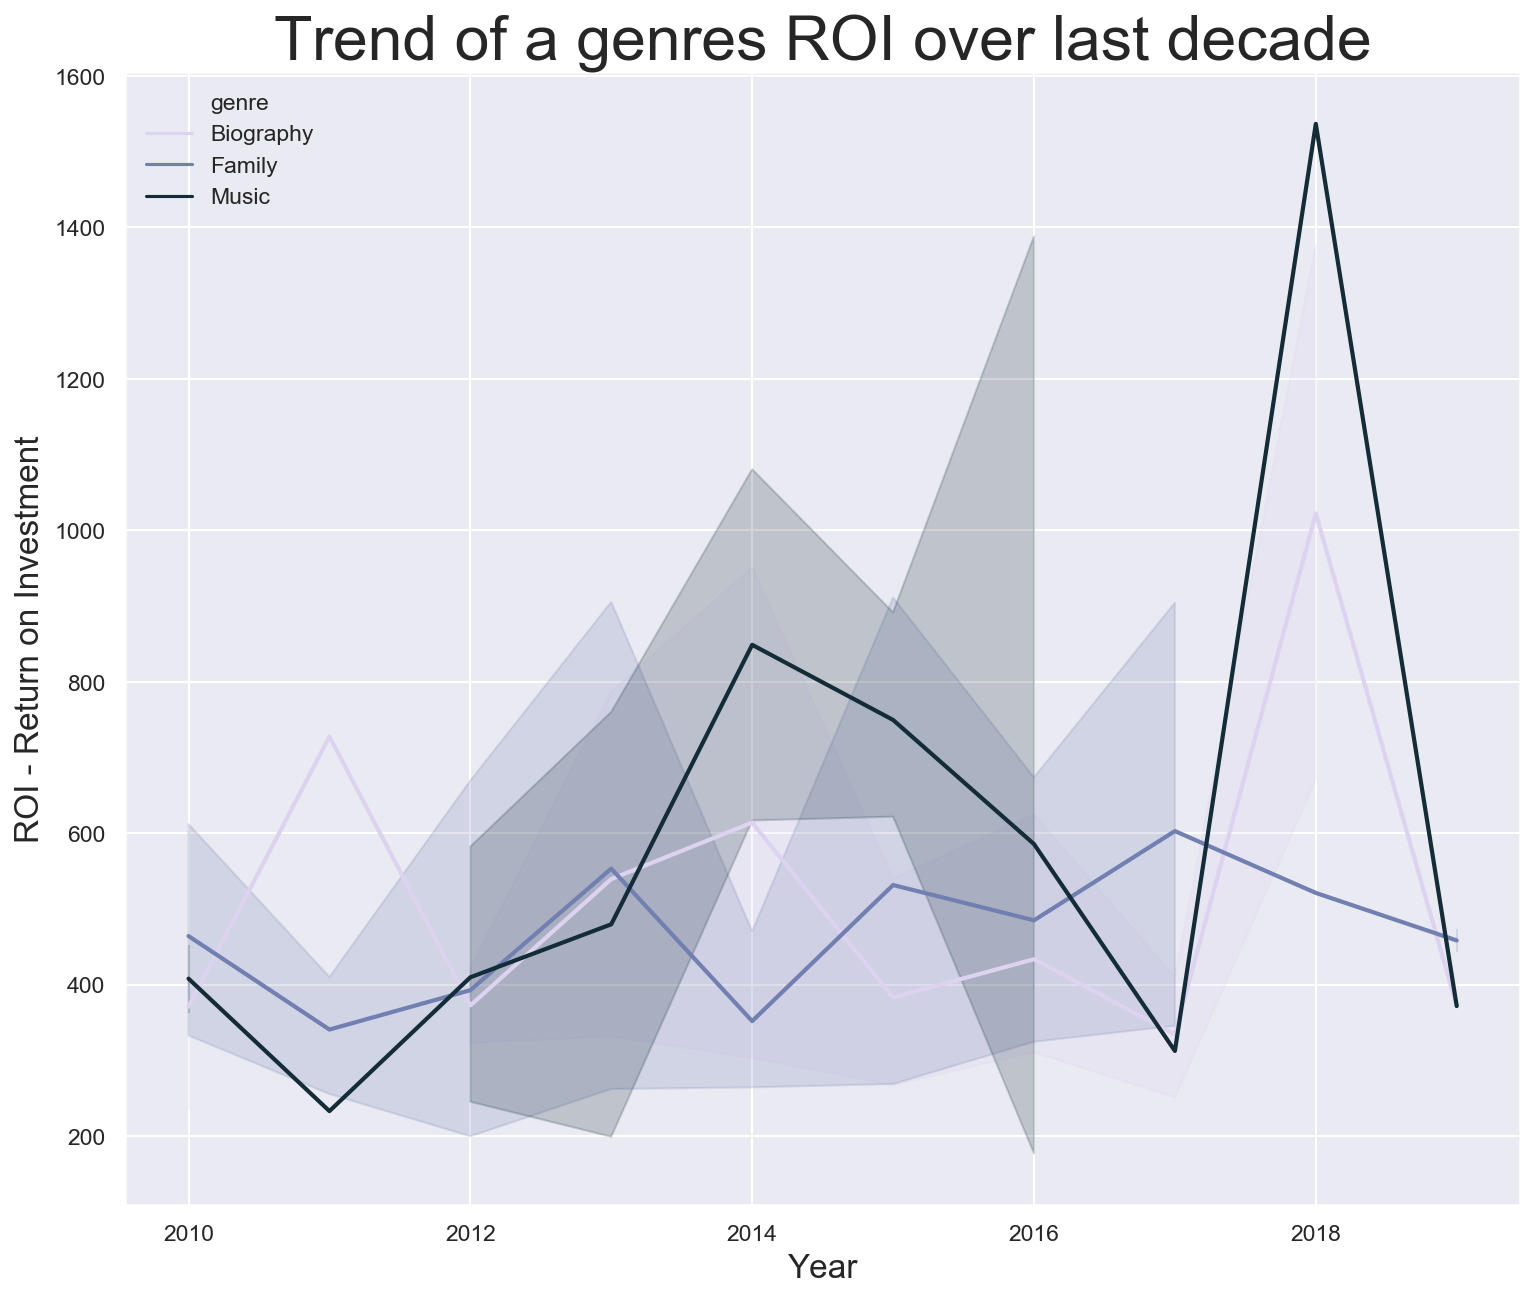

In [52]:
#Checking for trends across other high ROI genres
sns.set(style="darkgrid")
plt.figure(figsize=(12,10), dpi = 150)
sns.lineplot(x="year", y="roi",
             hue="genre", hue_order=['Biography', 'Family', 'Music'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.0)

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment', fontsize = 16)
plt.xlabel("Year", fontsize = 16)

# Add a title for the plot
plt.title('Trend of a genres ROI over last decade', fontsize = 30)

Text(0.5, 1.0, 'Trend of a genres ROI over last decade')

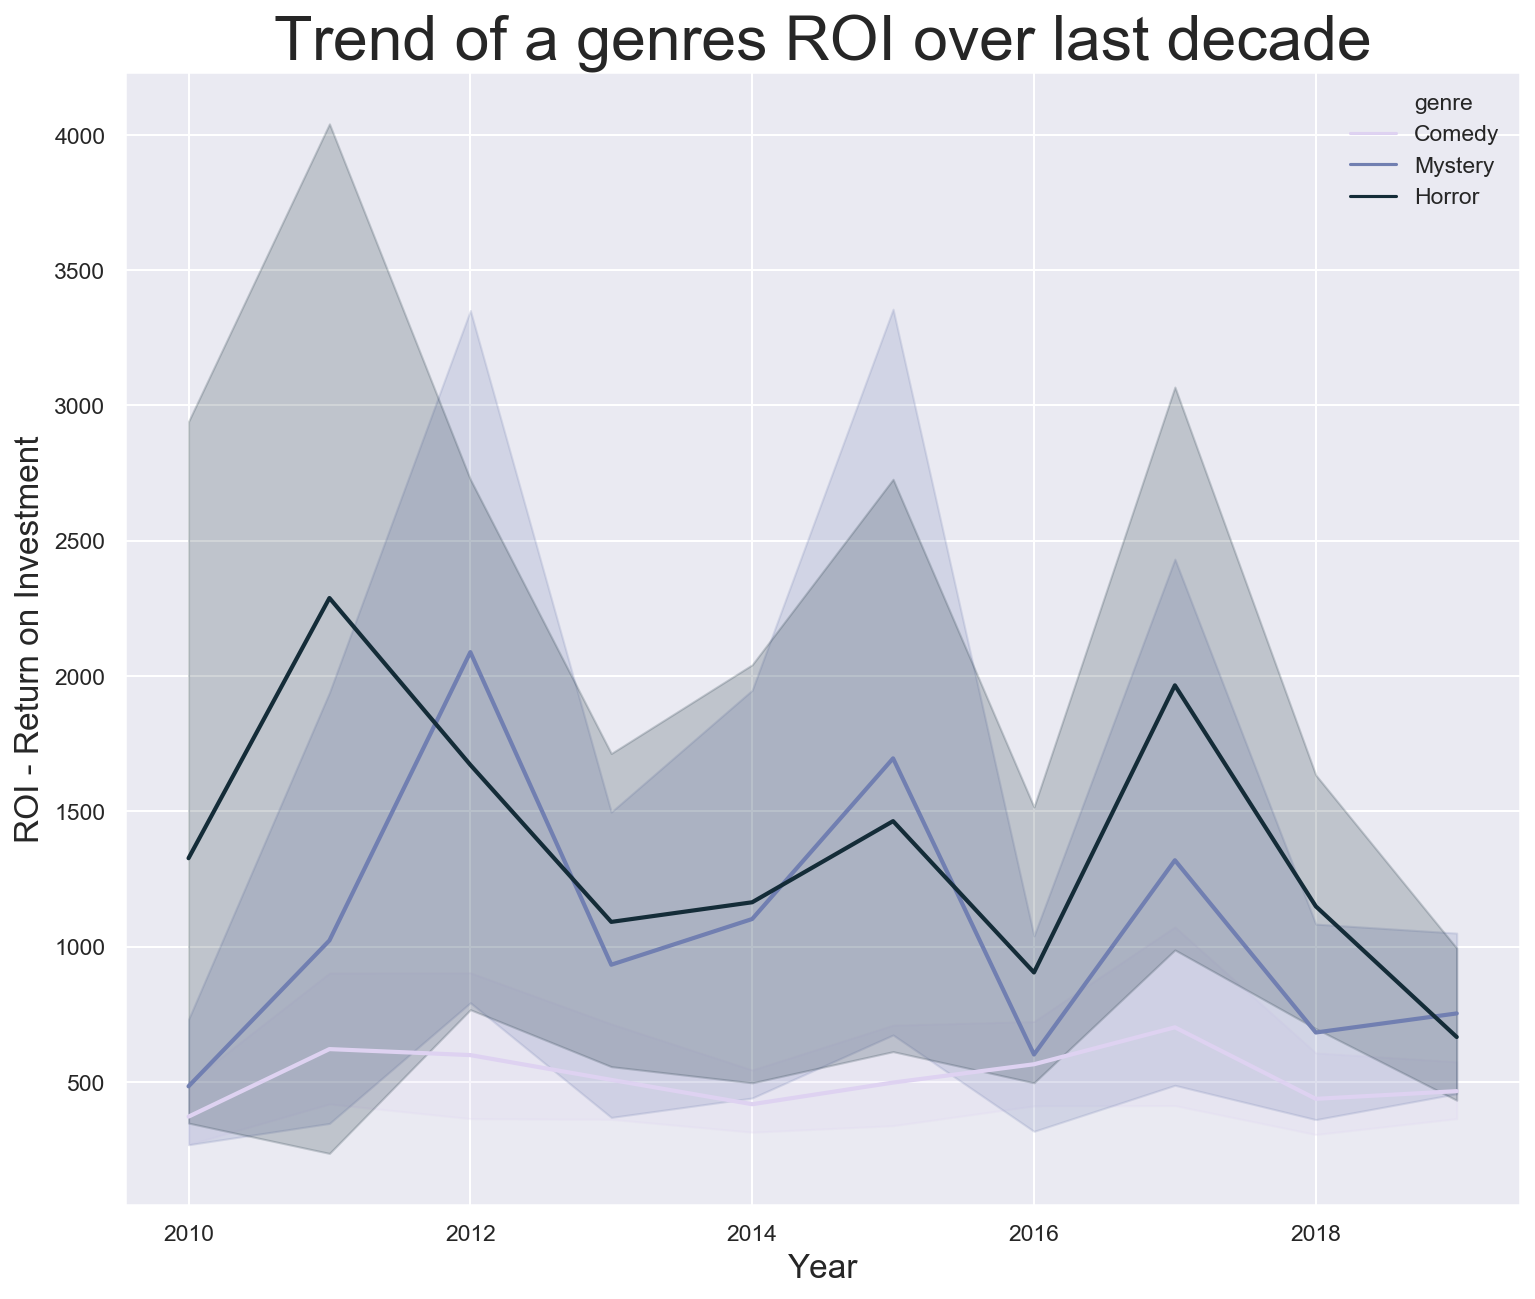

In [65]:
#Narrowing the selection
sns.set(style="darkgrid")
plt.figure(figsize=(12,10), dpi = 150)
sns.lineplot(x="year", y="roi",
             hue="genre", hue_order=['Comedy', 'Mystery', 'Horror'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.0)

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment', fontsize = 16)
plt.xlabel("Year", fontsize = 16)

# Add a title for the plot
plt.title('Trend of a genres ROI over last decade', fontsize = 30)

Text(0.5, 1.0, 'Trend of a genres ROI over last decade')

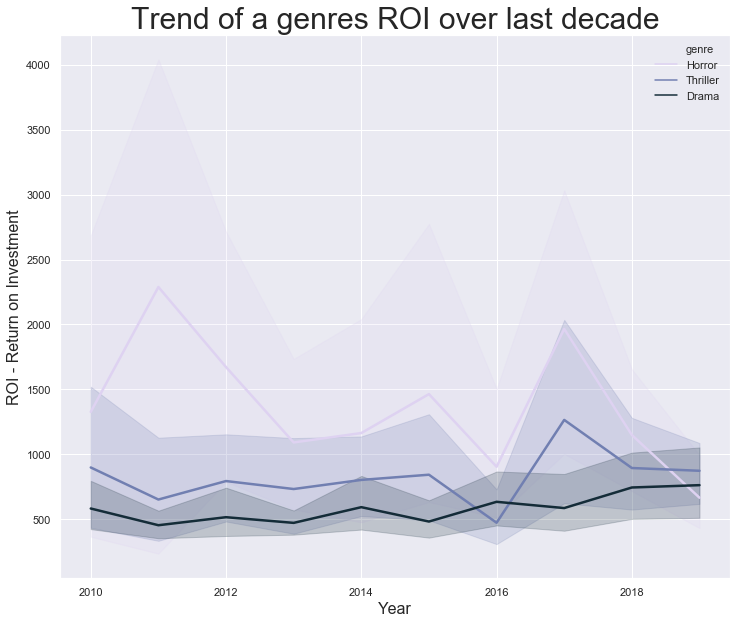

In [54]:
#Closing on the top trending genres in respect to ROI
sns.set(style="darkgrid")
plt.figure(figsize=(12,10), dpi = 150)
sns.lineplot(x="year", y="roi",
             hue="genre", hue_order=['Horror', 'Thriller', 'Drama'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.5)

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment', fontsize = 16)
plt.xlabel("Year", fontsize = 16)

# Add a title for the plot
plt.title('Trend of a genres ROI over last decade', fontsize = 30)

Text(0.5, 1.0, 'Production Budget for Genres with the Highest ROI over Ten Years')

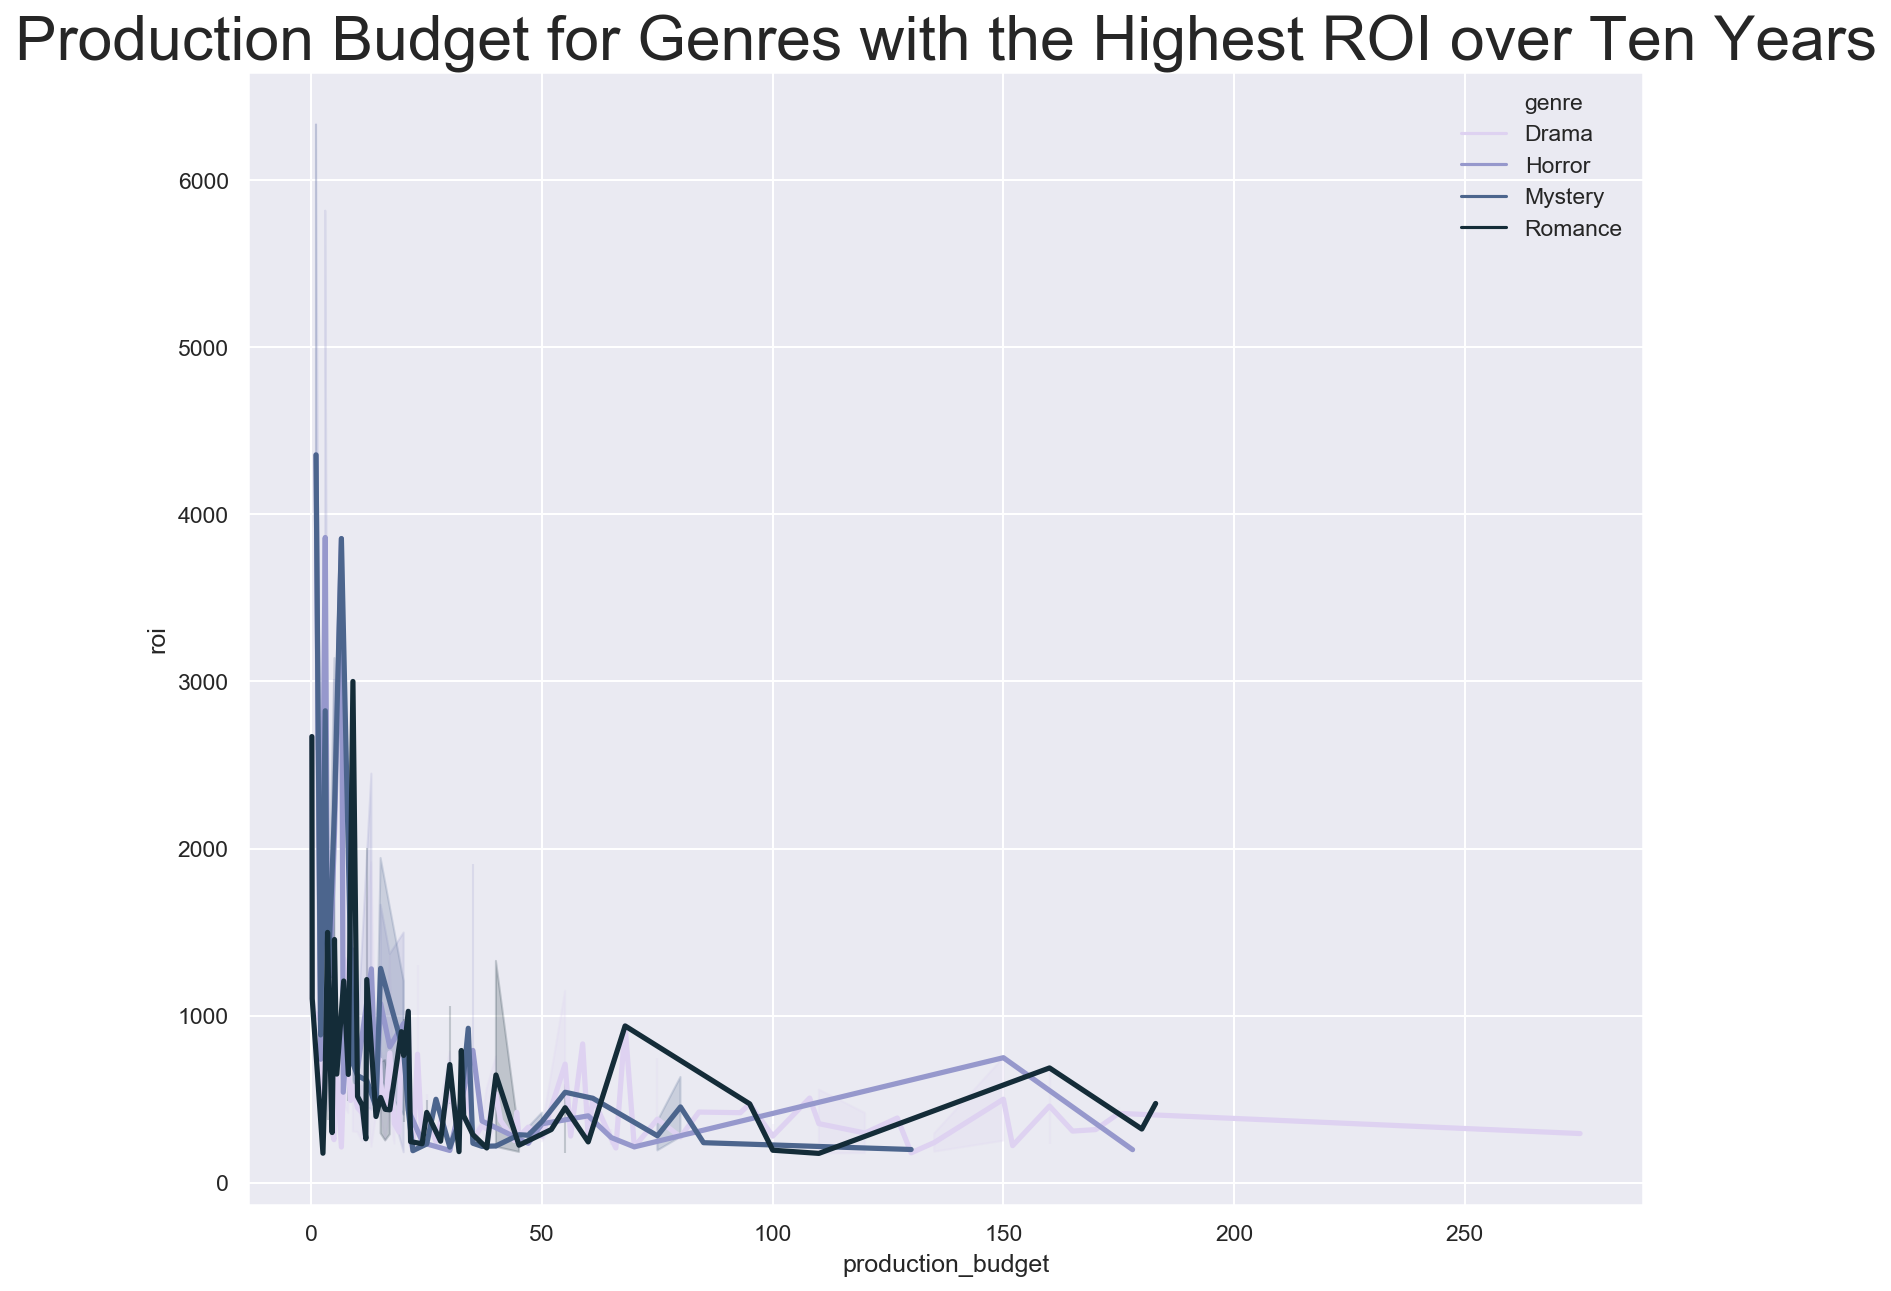

In [55]:
#Investigating findings before finalizing conclusions

sns.set(style="darkgrid")
plt.figure(figsize=(12,10), dpi = 150)
sns.lineplot(x="production_budget", y="roi",
             hue="genre", hue_order=['Drama', 'Horror', 'Mystery', 'Romance'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.5)
plt.title('Production Budget for Genres with the Highest ROI over Ten Years', fontsize = 30)


Text(0.5, 0, 'Year')

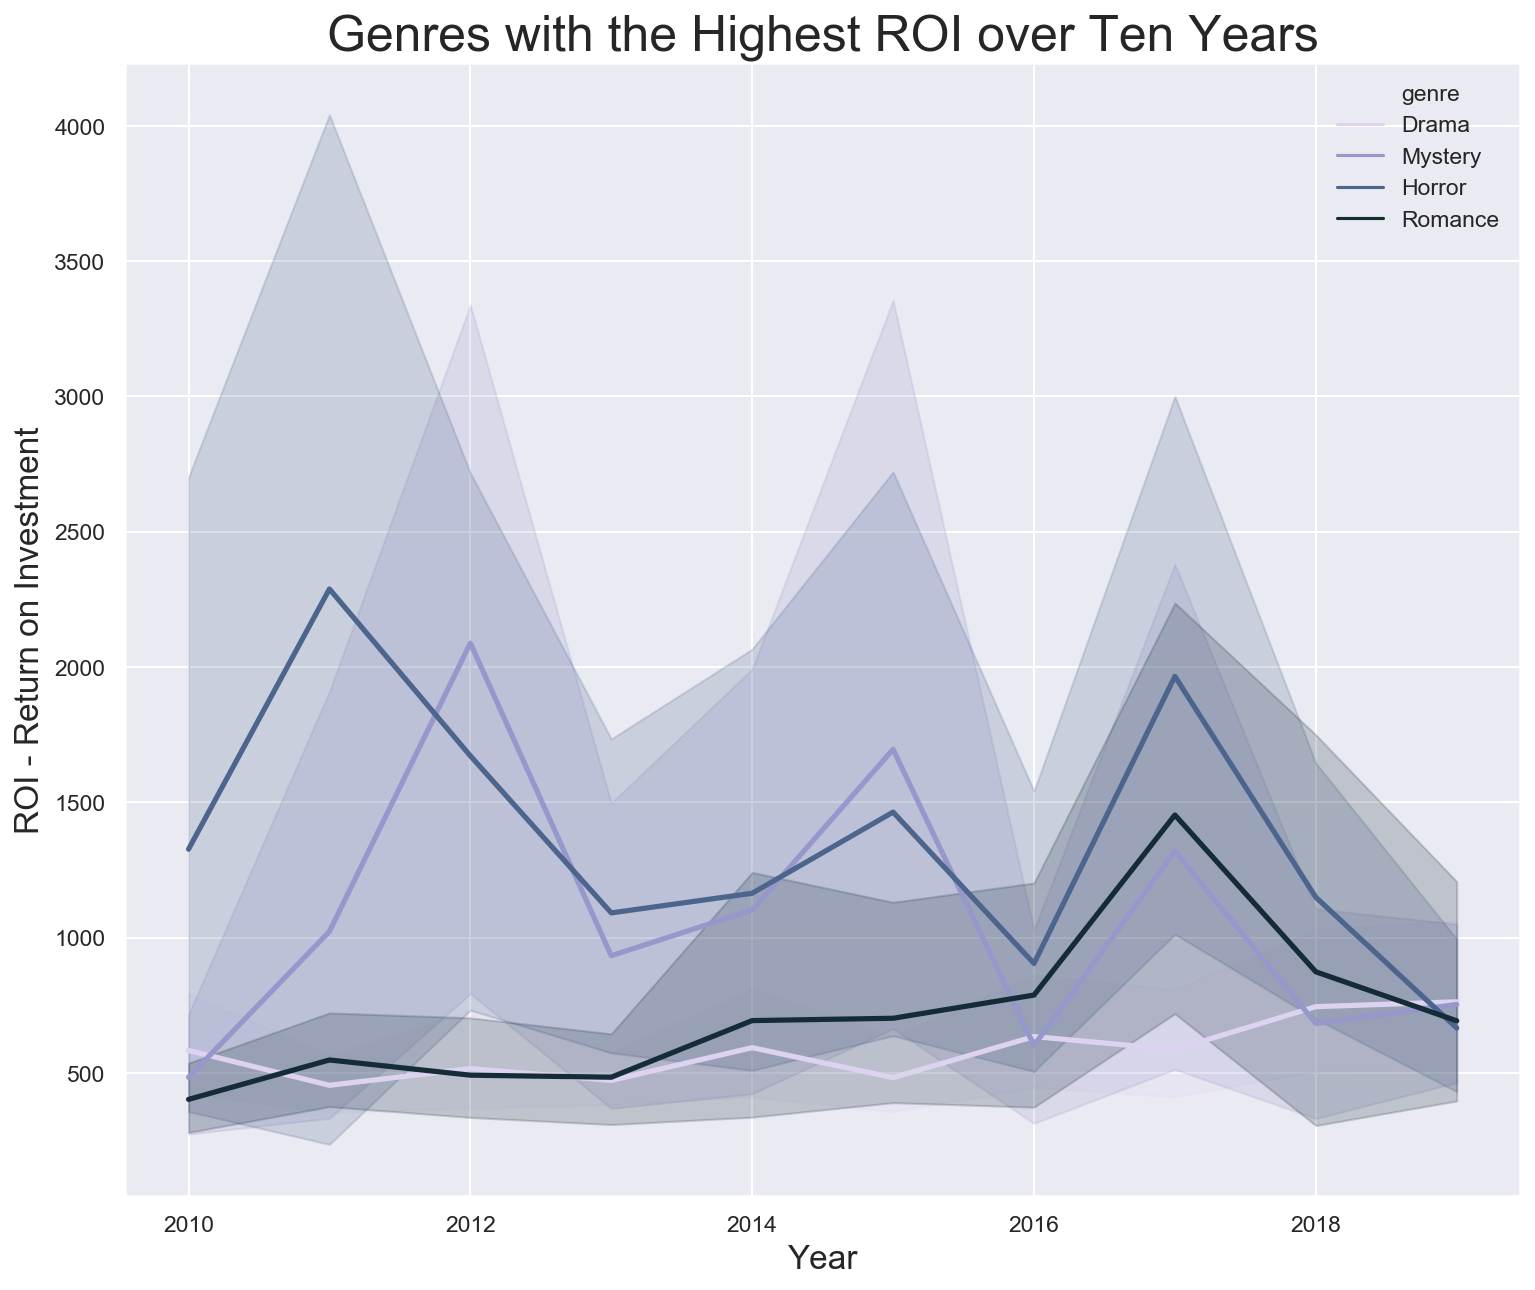

In [56]:
sns.set(style="darkgrid")
plt.figure(figsize=(12,10), dpi = 150)
sns.lineplot(x="year", y="roi",
             hue="genre", hue_order=['Drama', 'Mystery', 'Horror', 'Romance'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.5)
plt.title('Genres with the Highest ROI over Ten Years', fontsize = 24)

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment', fontsize = 16)
plt.xlabel("Year", fontsize = 16)

Jessica

In [57]:
# Creating Function for ROI
def roi (gross, budget):
    percentage = (gross-budget)/budget * 100
    return (percentage)

# Expanding the Genres column
plot_df_roi = genre_expand(final_df)

# Calculating ROI
plot_df_roi['domestic_roi'] = roi(plot_df_roi['domestic_gross'], plot_df_roi['production_budget'])
plot_df_roi['foreign_roi'] = roi(plot_df_roi['foreign_gross'], plot_df_roi['production_budget'])
plot_df_roi['worldwide_roi'] = roi(plot_df_roi['worldwide_gross'], plot_df_roi['production_budget'])

# Extracting the Month
plot_df_roi['year'] = pd.DatetimeIndex(plot_df_roi['release_date']).year


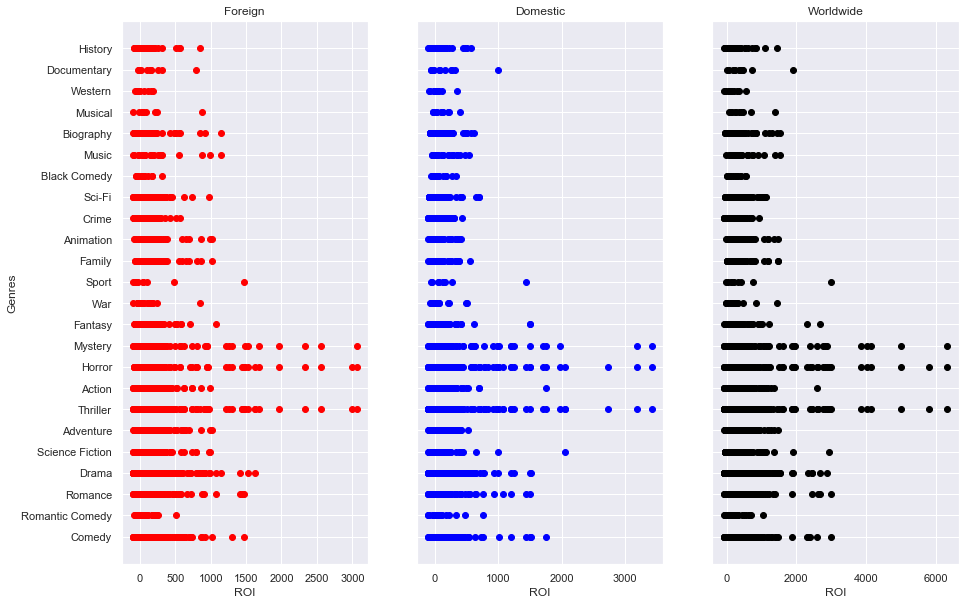

In [58]:
sns.set()

# Important Values
x = plot_df_roi['genre']
f = plot_df_roi['foreign_roi']
d = plot_df_roi['domestic_roi']
w = plot_df_roi['worldwide_roi']

# Create Figure and Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize =(15, 10))

# Plot
ax1.scatter(f, x, color='red')  
ax2.scatter(d, x, color='blue')
ax3.scatter(w, x, color='black')

# Title, X and Y labels
ax1.set_title('Foreign'); ax2.set_title('Domestic'); ax3.set_title('Worldwide');
ax1.set_xlabel('ROI');  ax2.set_xlabel('ROI'); ax3.set_xlabel('ROI'); # x label
ax1.set_ylabel('Genres'); # y label

# Output the final plot
plt.show()

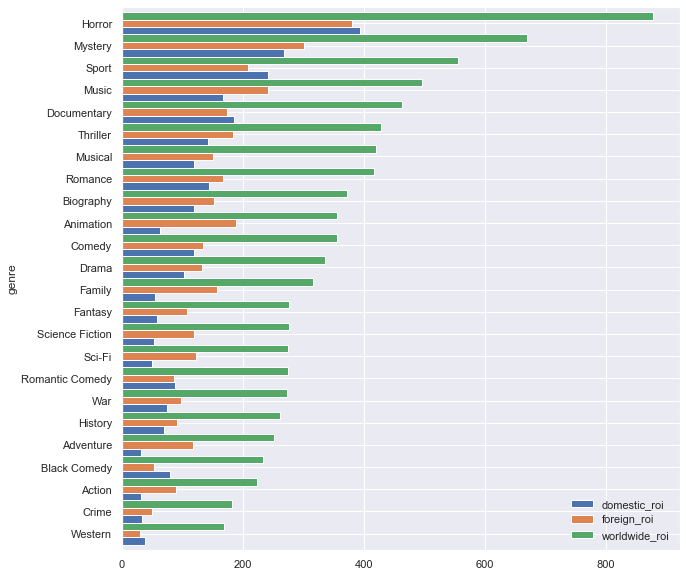

In [59]:
averageroi = plot_df_roi.groupby(['genre'], as_index=False).mean()
drop_columns = ['year', 'genres_count','worldwide_gross','production_budget','domestic_gross','foreign_gross','roi']
averageroi = averageroi.drop(drop_columns, axis=1)
averageroi = averageroi.sort_values('worldwide_roi', ascending=True, ignore_index=True)
averageroi.plot.barh(x='genre', width=1, figsize=(10,10))

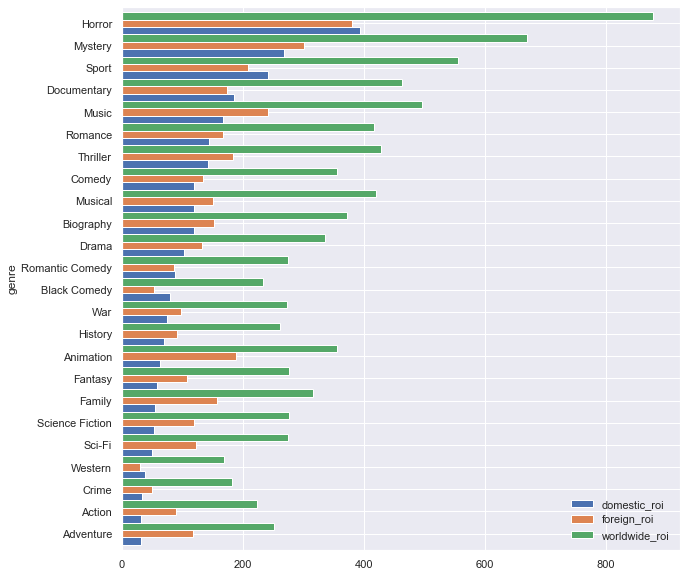

In [60]:
averageroi = averageroi.sort_values('domestic_roi', ignore_index=True)
averageroi.plot.barh(x='genre', width=1, figsize=(10,10))

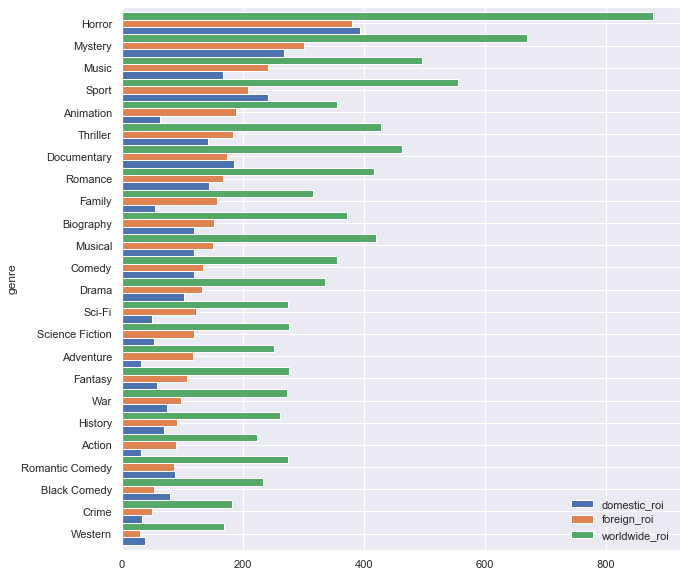

In [61]:
averageroi = averageroi.sort_values('foreign_roi', ignore_index=True)
averageroi.plot.barh(x='genre', width=1, figsize=(10,10))

Talk about this section.

In [62]:
# Create a new column that evenly distributes the worldwide_gross of a movie for the amount of genres of that movie. 
plot_df_roi['worldwide_gross_distributed'] = plot_df_roi['worldwide_gross'] / plot_df_roi['genres_count']
plot_df_roi.head()

,release_date,title,production_budget,domestic_gross,foreign_gross,worldwide_gross,roi,year,genres_count,genre,domestic_roi,foreign_roi,worldwide_roi,worldwide_gross_distributed
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Comedy,36.415368,-64.736842,71.678526,10.872973
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Romantic Comedy,36.415368,-64.736842,71.678526,10.872973
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Romance,36.415368,-64.736842,71.678526,10.872973
1,2010-01-11,The Book of Eli,80.0,94.835059,63.915758,158.750817,98.438521,2010,5,Drama,18.543824,-20.105303,98.438521,31.750163
1,2010-01-11,The Book of Eli,80.0,94.835059,63.915758,158.750817,98.438521,2010,5,Science Fiction,18.543824,-20.105303,98.438521,31.750163


In [63]:
#Group by 'genre' and sum the values of the worldwide_gross_distribution
ww_gross = plot_df_roi.groupby(['genre'], as_index=False).sum()

#Combine all the genres that net under $10 billion to a new category 'Other'
ww_gross_filtered = ww_gross[ww_gross['worldwide_gross_distributed'] >= 5000]
ww_gross_others = ww_gross[ww_gross['worldwide_gross_distributed'] < 5000].sum().to_frame()

#Rename the column
ww_gross_others[0][0] = 'Other'

#Merge the combined 'Other' category to the main dataframe
ww_gross_filtered = ww_gross_filtered.append(ww_gross_others.T, ignore_index=True)

#Sort the value by 'worldwide_gross_distributed'
ww_gross_filtered = pd.DataFrame.from_dict(ww_gross_filtered).sort_values( by ='worldwide_gross_distributed', ascending = False)

#Drop all unneeded columns
ww_gross_filtered = ww_gross_filtered.drop(ww_gross_filtered.columns[1:-1], axis=1)
ww_gross_filtered.head()

,genre,worldwide_gross_distributed
1,Adventure,26045.9
0,Action,25026.9
3,Comedy,18963.5
12,Other,17849.3
5,Drama,16433


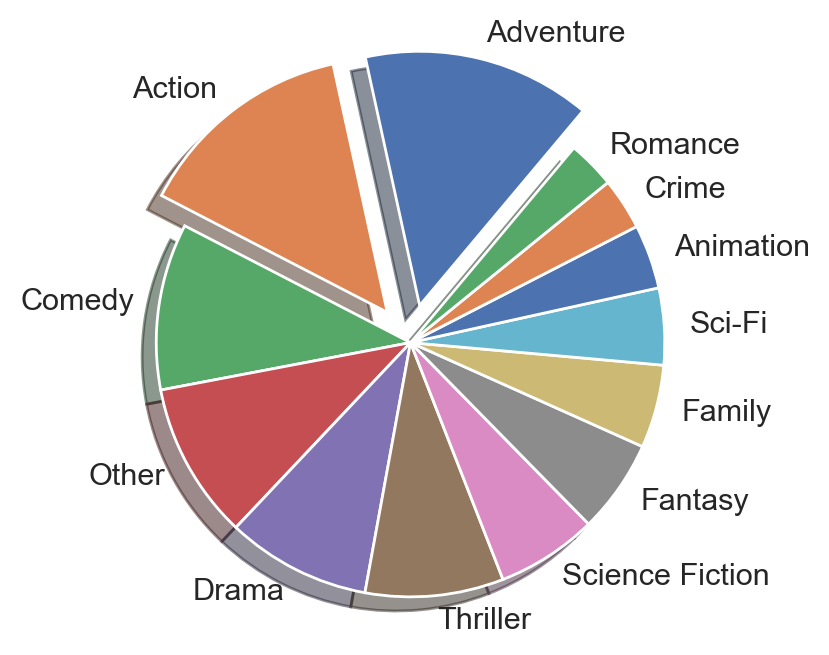

In [64]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ww_gross_filtered['genre']
sizes = ww_gross_filtered['worldwide_gross_distributed']

explode = np.zeros(len(sizes))

#Explode the 'Action' and 'Adventure' slices
explode[0:2] = .15

fig1, ax1 = plt.subplots(figsize=(4,4), dpi= 200)
ax1.pie(sizes, labels=labels, explode=explode,
        shadow=True, startangle = 50)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()